# Importing Libraries

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from persiantools.jdatetime import JalaliDate
from mpl_toolkits.basemap import Basemap

# Data Preparation

## Loading Datasets

In [221]:
geography = pd.read_csv(f"Dataset/Geography Information.csv")
geography['city'] = geography['city'].str.strip()
print(geography)

    latitude  longitude  elevation          city
0  35.676624  51.428570     1183.0        Tehran
1  38.066784  46.150738     1399.0        Tabriz
2  36.309315  59.648438      986.0       Mashhad
3  32.653778  51.695120     1579.0       Isfahan
4  29.630930  52.560837     1541.0        Shiraz
5  31.318100  48.700836       23.0         Ahvaz
6  37.293495  49.535810        4.0         Rasht
7  30.263618  57.119434     1762.0        Kerman
8  27.170473  56.224940        9.0  Bandar Abbas
9  35.817223  50.980644     1341.0         Karaj


In [222]:
# City name lists
cities = [
    "Tehran",
    "Karaj",
    "Tabriz",
    "Mashhad",
    "Isfahan",
    "Shiraz",
    "Ahvaz",
    "Rasht",
    "Kerman",
    "Bandar Abbas"
]

# list to keep dataframes
dataframes = []

# Reading DataFrames and Saving them in a dictionary
for city in cities:
    df = pd.read_csv(f"Dataset/{city}.csv")
    df['city'] = city
    dataframes.append(df)

### Dataset Combining 

In [223]:
## Data Cleaning 
df_combined = pd.concat(dataframes, ignore_index=True)
df_combined = pd.merge(df_combined, geography, on='city', how='left')

# Save the combined dataframe to a new CSV file
df_combined.to_csv("Dataset/Combined Dataset.csv", index=False)

## Data Cleaning 

In [224]:
del df, df_combined, dataframes, geography, cities
df = pd.read_csv("Dataset/Combined Dataset.csv")

### Checking NaNs 

In [225]:
print("Dataset Missing Values:")
missing_values = df.isnull().sum()
print(missing_values)

Dataset Missing Values:
time                               0
temp_max (°C)                      0
temp_min (°C)                      0
temp_mean (°C)                     0
daylight_duration (s)              0
precipitation_sum (mm)             0
rain_sum (mm)                      0
snowfall_sum (cm)                  0
precipitation_hours (h)            0
wind_speed_max (km/h)              0
wind_gusts_max (km/h)              0
wind_direction_dominant (°)        0
shortwave_radiation_sum (MJ/m²)    0
evapotranspiration (mm)            0
city                               0
latitude                           0
longitude                          0
elevation                          0
dtype: int64


### Gregorian and Jalali Date Settings 

In [226]:
df["time"] = pd.to_datetime(df["time"])

In [227]:
# create Jalali date column
df["date_jalali"] = df["time"].apply(lambda time: JalaliDate(time)) 

# rename time to date_gregorian
df.rename(columns={'time': 'date_gregorian'}, inplace=True)

In [228]:

df["year"] = df["date_jalali"].apply(lambda date: date.year)
df["month"] = df["date_jalali"].apply(lambda date: date.month)
df["season"] = df["month"].apply(lambda month:
                                    "Spring" if month in [1, 2, 3] else 
                                    "Summer" if month in [4, 5, 6] else 
                                    "Autumn" if month in [7, 8, 9] else 
                                    "Winter")
df['month'] = df['month'].map({
    1: "Farvardin",
    2: "Ordibehesht",
    3: "Khordad",
    4: "Tir",
    5: "Mordad",
    6: "Shahrivar",
    7: "Mehr",
    8: "Aban",
    9: "Azar",
    10: "Dey",
    11: "Bahman",
    12: "Esfand"
})                       

### Adjusting Units

In [229]:
df["snowfall_sum (cm)"] = df["snowfall_sum (cm)"].apply(lambda item : item * 10)
df.rename(columns={'snowfall_sum (cm)': 'snowfall_sum (mm)'}, inplace=True)

df["daylight_duration (s)"] = df["daylight_duration (s)"].apply(lambda item : item / 3600)
df.rename(columns={'daylight_duration (s)': 'daylight_duration (h)'}, inplace=True)

### Additional Columns for easy Analysis

In [230]:
df["temp_diff (°C)"] = df["temp_max (°C)"] - df["temp_min (°C)"]
df["remain_precipitation (mm)"] = df["precipitation_sum (mm)"] - df["evapotranspiration (mm)"]

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49260 entries, 0 to 49259
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_gregorian                   49260 non-null  datetime64[ns]
 1   temp_max (°C)                    49260 non-null  float64       
 2   temp_min (°C)                    49260 non-null  float64       
 3   temp_mean (°C)                   49260 non-null  float64       
 4   daylight_duration (h)            49260 non-null  float64       
 5   precipitation_sum (mm)           49260 non-null  float64       
 6   rain_sum (mm)                    49260 non-null  float64       
 7   snowfall_sum (mm)                49260 non-null  float64       
 8   precipitation_hours (h)          49260 non-null  float64       
 9   wind_speed_max (km/h)            49260 non-null  float64       
 10  wind_gusts_max (km/h)            49260 non-null  float64  

### Memory Cleaning 

In [232]:
def datatype_cleaner(df):
    
    for column in df.select_dtypes(include=['float', 'int']).columns:
        min_val = df[column].min()
        max_val = df[column].max()
    
        col_dtype = df[column].dtype
    
        # Check ranges for int and float types
        if np.issubdtype(col_dtype, np.floating):
            if min_val >= -65504 and max_val <= 65504:  # float16
                df[column] = df[column].astype(np.float16)
            elif min_val >= -3.4e38 and max_val <= 3.4e38:  # float32
                df[column] = df[column].astype(np.float32)
            else:
                df[column] = df[column].astype(np.float64)
    
        elif np.issubdtype(col_dtype, np.integer):
            if min_val >= -128 and max_val <= 127:  # int8
                df[column] = df[column].astype(np.int8)
            elif min_val >= -32768 and max_val <= 32767:  # int16
                df[column] = df[column].astype(np.int16)
            elif min_val >= -2147483648 and max_val <= 2147483647:  # int32
                df[column] = df[column].astype(np.int32)
            else:
                df[column] = df[column].astype(np.int64)

In [233]:
# calling the function to clean datatype memory usage
datatype_cleaner(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49260 entries, 0 to 49259
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_gregorian                   49260 non-null  datetime64[ns]
 1   temp_max (°C)                    49260 non-null  float16       
 2   temp_min (°C)                    49260 non-null  float16       
 3   temp_mean (°C)                   49260 non-null  float16       
 4   daylight_duration (h)            49260 non-null  float16       
 5   precipitation_sum (mm)           49260 non-null  float16       
 6   rain_sum (mm)                    49260 non-null  float16       
 7   snowfall_sum (mm)                49260 non-null  float16       
 8   precipitation_hours (h)          49260 non-null  float16       
 9   wind_speed_max (km/h)            49260 non-null  float16       
 10  wind_gusts_max (km/h)            49260 non-null  float16  

In [234]:
df.to_csv("Final Dataset.csv", index=False)

# Data Visualization

## Temperature Analysis

### Yearly Line plot

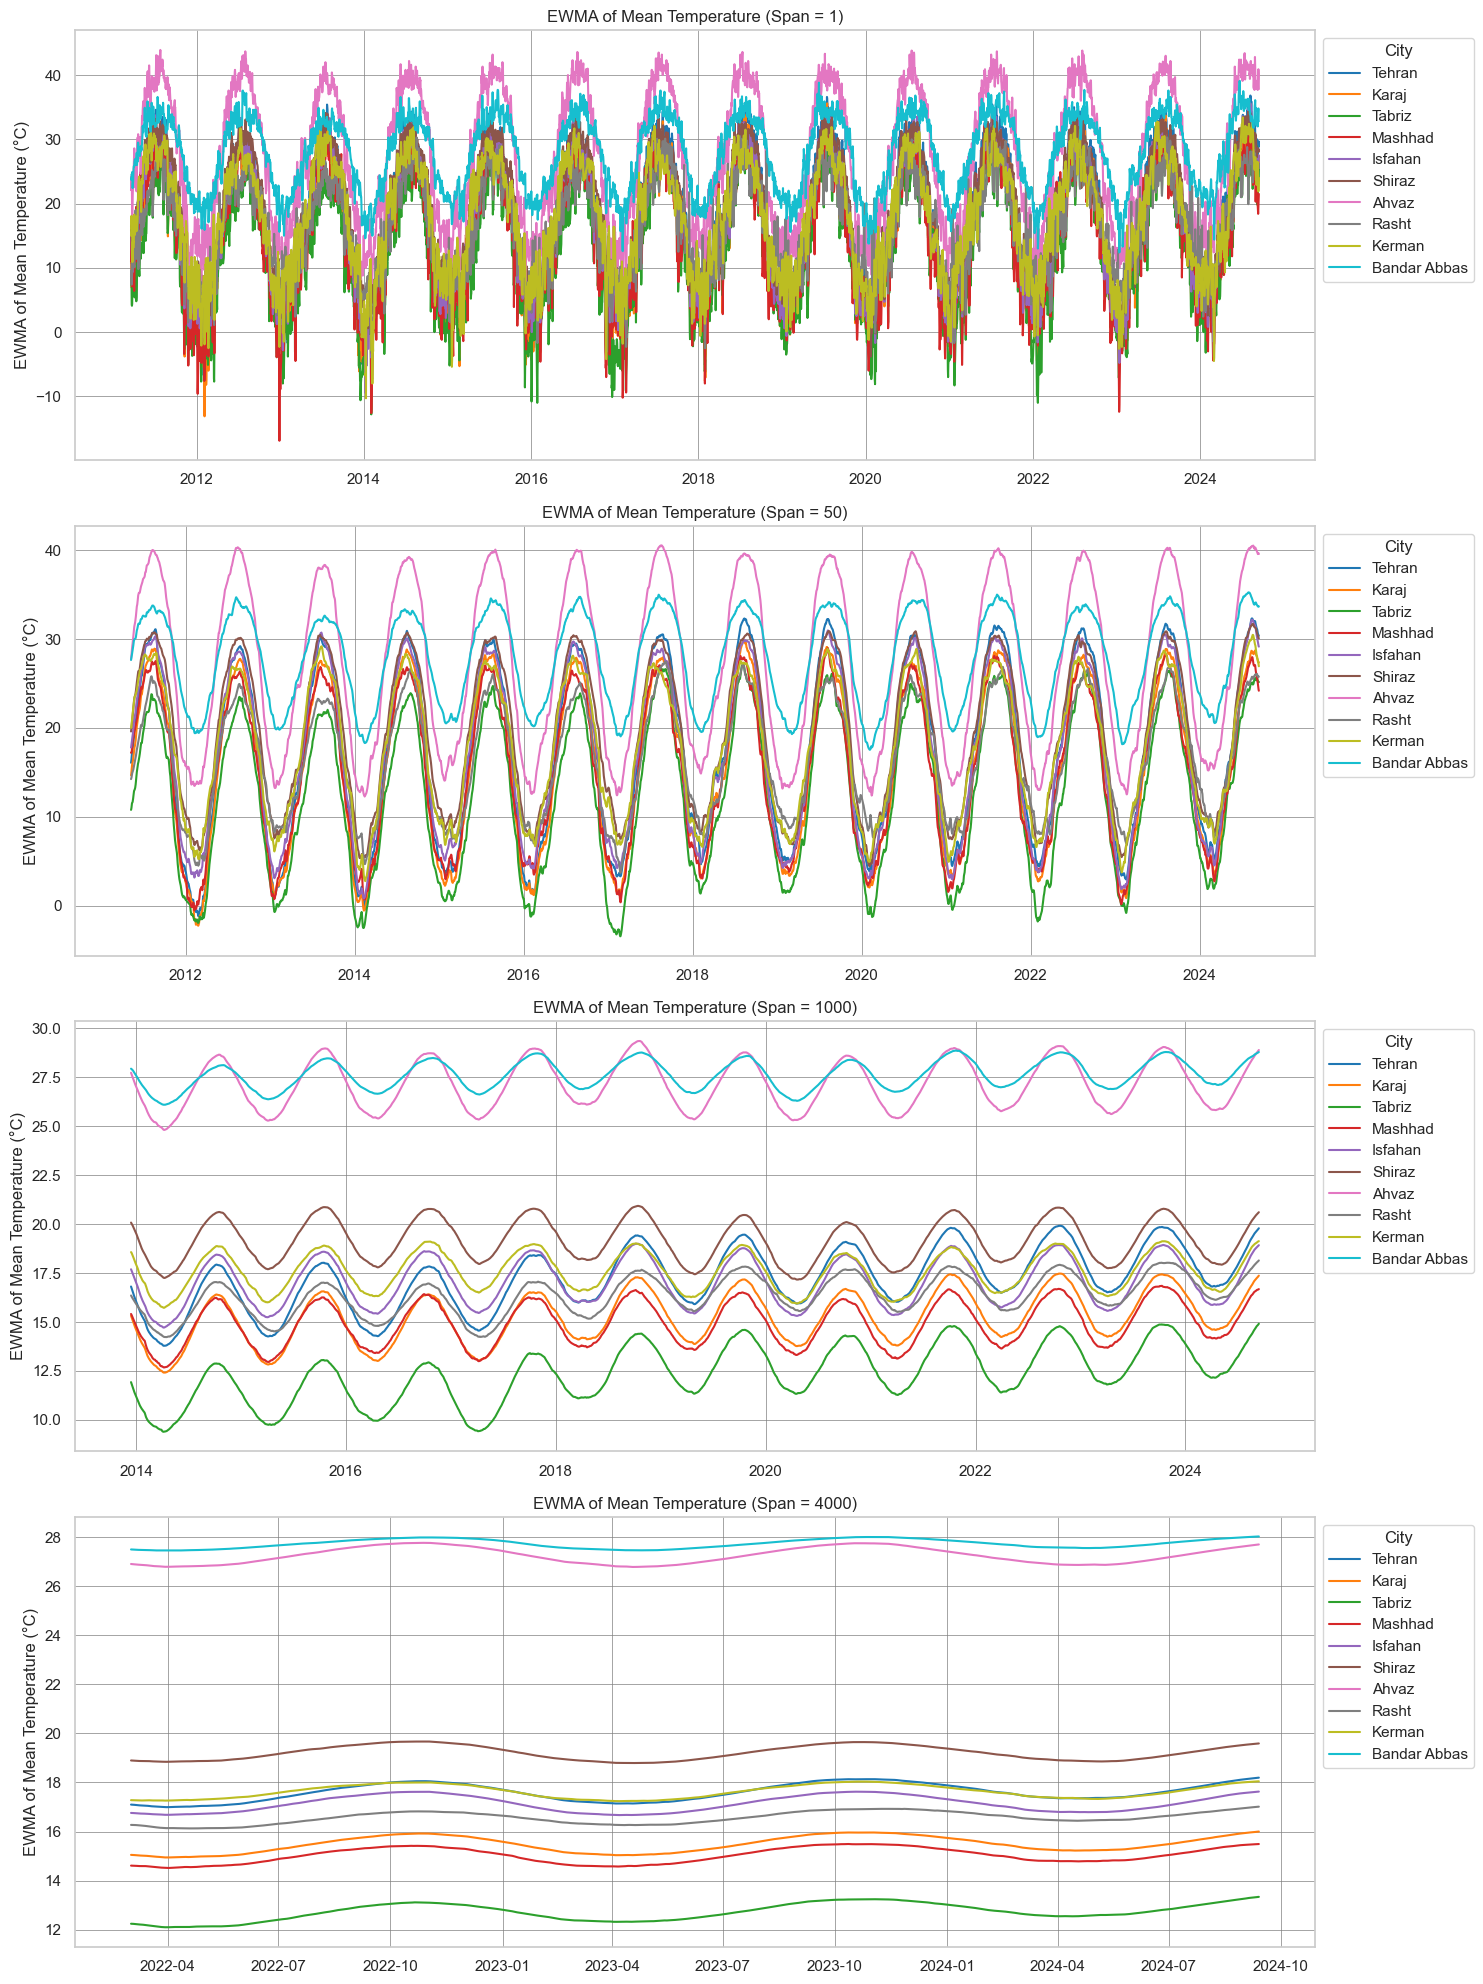

In [235]:
spans = [1, 50, 1000, 4000]
pallet = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig, axs = plt.subplots(len(spans), 1, figsize=(15, 20))
cities = df['city'].unique()

for i, span in enumerate(spans):
    for j, city in enumerate(cities):
        city_data = df[df['city'] == city].set_index('date_gregorian')
        ewma_temp = city_data['temp_mean (°C)'].ewm(span=span).mean()
        
        # Determine the starting point for plotting
        start_index = ewma_temp.index[span - 1]
        axs[i].plot(ewma_temp.index[span - 1:], ewma_temp[span - 1:], label=city, color=pallet[j % len(pallet)])

    axs[i].set_title(f"EWMA of Mean Temperature (Span = {spans[i]})")
    axs[i].set_ylabel("EWMA of Mean Temperature (°C)")
    axs[i].legend(title="City", bbox_to_anchor=(1, 1), loc='upper left')
    axs[i].grid(True, color='gray', linewidth=0.5) 

plt.tight_layout()
plt.show()

del spans, pallet, axs, fig, city_data, ewma_temp, cities, start_index

### Temperature : City-wise Seasonal Analysis

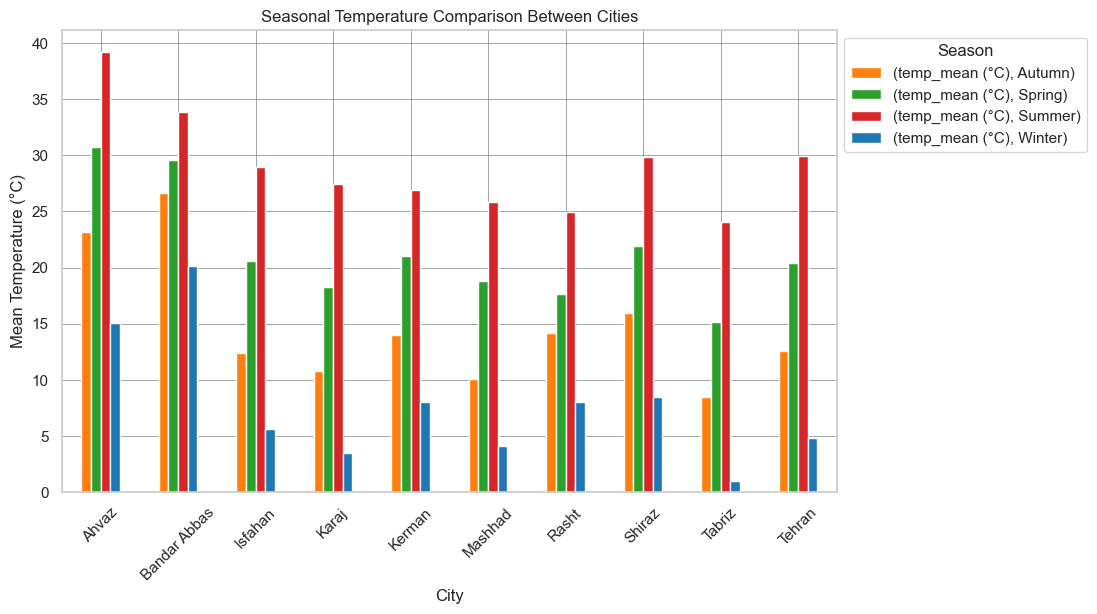

In [236]:
city_season_trends = df.groupby(['city', 'season']).agg({
    'temp_mean (°C)': 'mean',
}).unstack()

pallet = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4']
ax = city_season_trends.plot(kind='bar', figsize=(10, 6), color=pallet)

plt.title("Seasonal Temperature Comparison Between Cities")
plt.xlabel("City")
plt.ylabel("Mean Temperature (°C)")
plt.legend(title="Season", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 
plt.xticks(rotation=45)
plt.show()

del city_season_trends

### Max, Min and Mean City-Wise Temperature Analysis

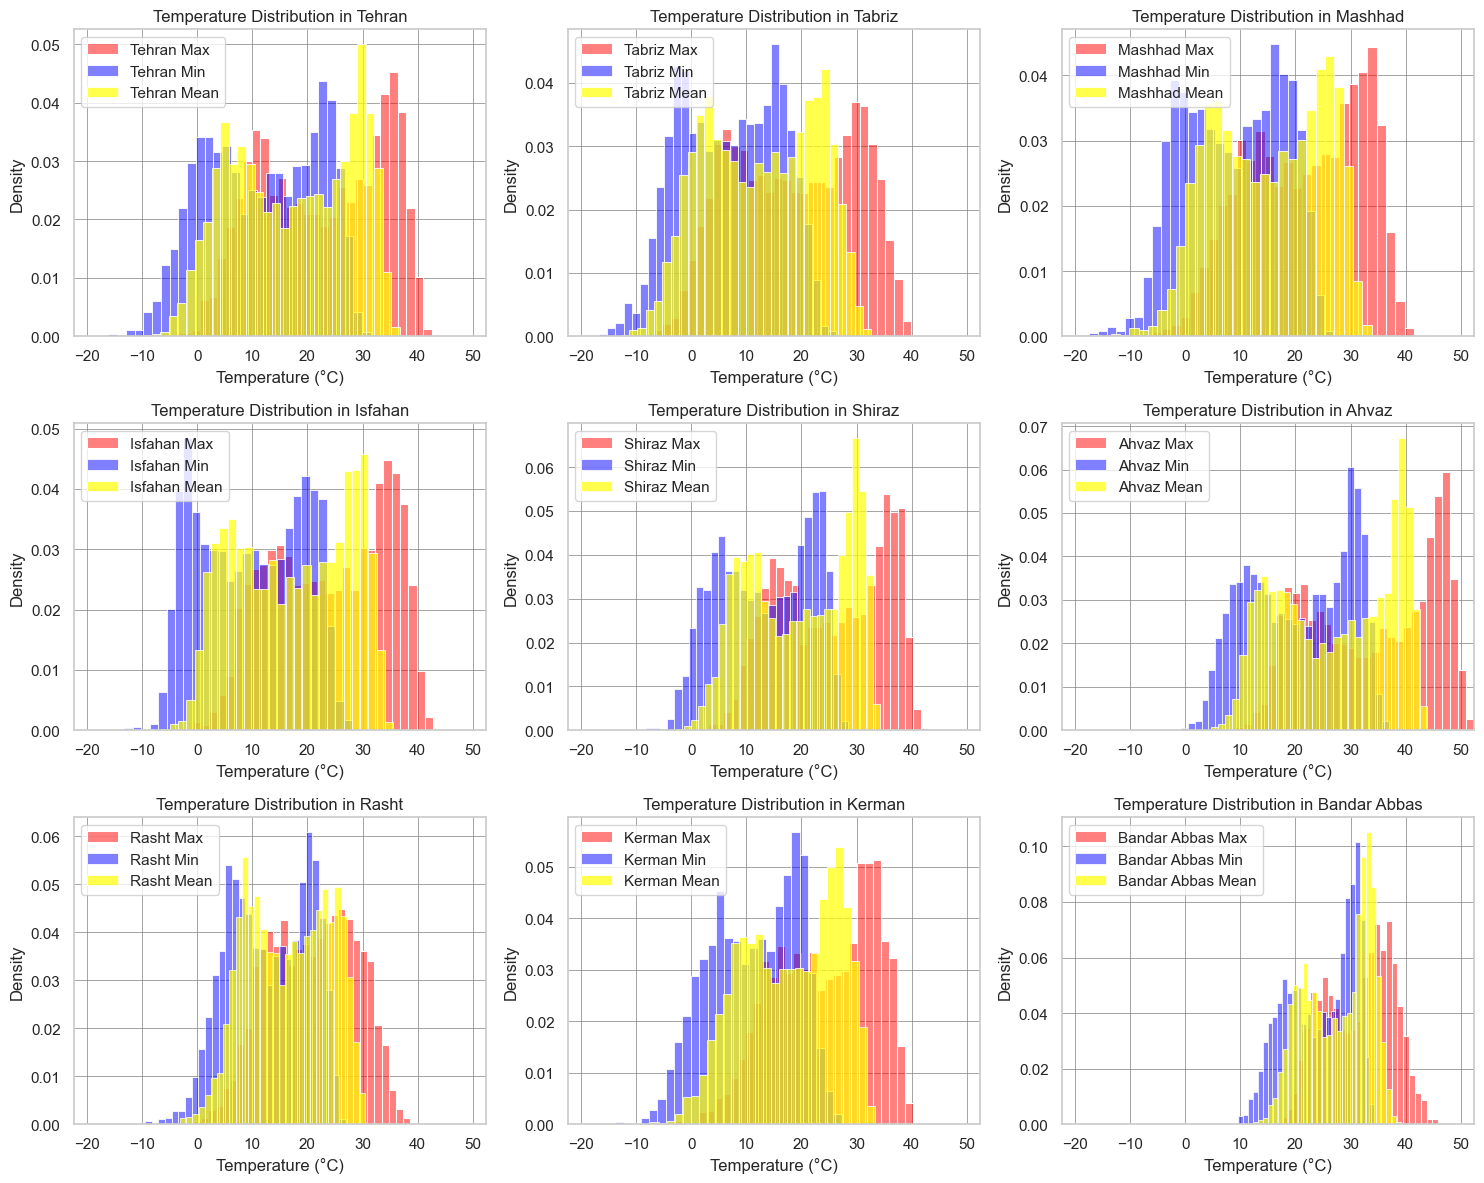

In [237]:
cities = [city for city in df['city'].unique() if city != 'Karaj']
overall_min = df[['temp_min (°C)', 'temp_mean (°C)', 'temp_max (°C)']].min().min()
overall_max = df[['temp_min (°C)', 'temp_mean (°C)', 'temp_max (°C)']].max().max()

plt.figure(figsize=(15, 12))
sns.set(style="whitegrid")

for i, city in enumerate(cities, 1):
    plt.subplot(3, 3, i)
    subset = df[df['city'] == city]
    
    sns.histplot(subset['temp_max (°C)'], bins=30, kde=False, color='red', alpha=0.5, label=f'{city} Max', stat='density')
    sns.histplot(subset['temp_min (°C)'], bins=30, kde=False, color='blue', alpha=0.5, label=f'{city} Min', stat='density')
    sns.histplot(subset['temp_mean (°C)'], bins=30, kde=False, color='yellow', alpha=0.7, label=f'{city} Mean', stat='density')

    # Set x and y limits for uniformity
    plt.xlim(overall_min, overall_max)
    plt.ylim(0, None) 

    plt.title(f'Temperature Distribution in {city}')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Density')
    plt.legend(loc='upper left')
    plt.grid(True, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()


del cities, subset, overall_max, overall_min

### Distance between Max and Min Temperature

#### Temperature Distance : Line plot for 6 important cities

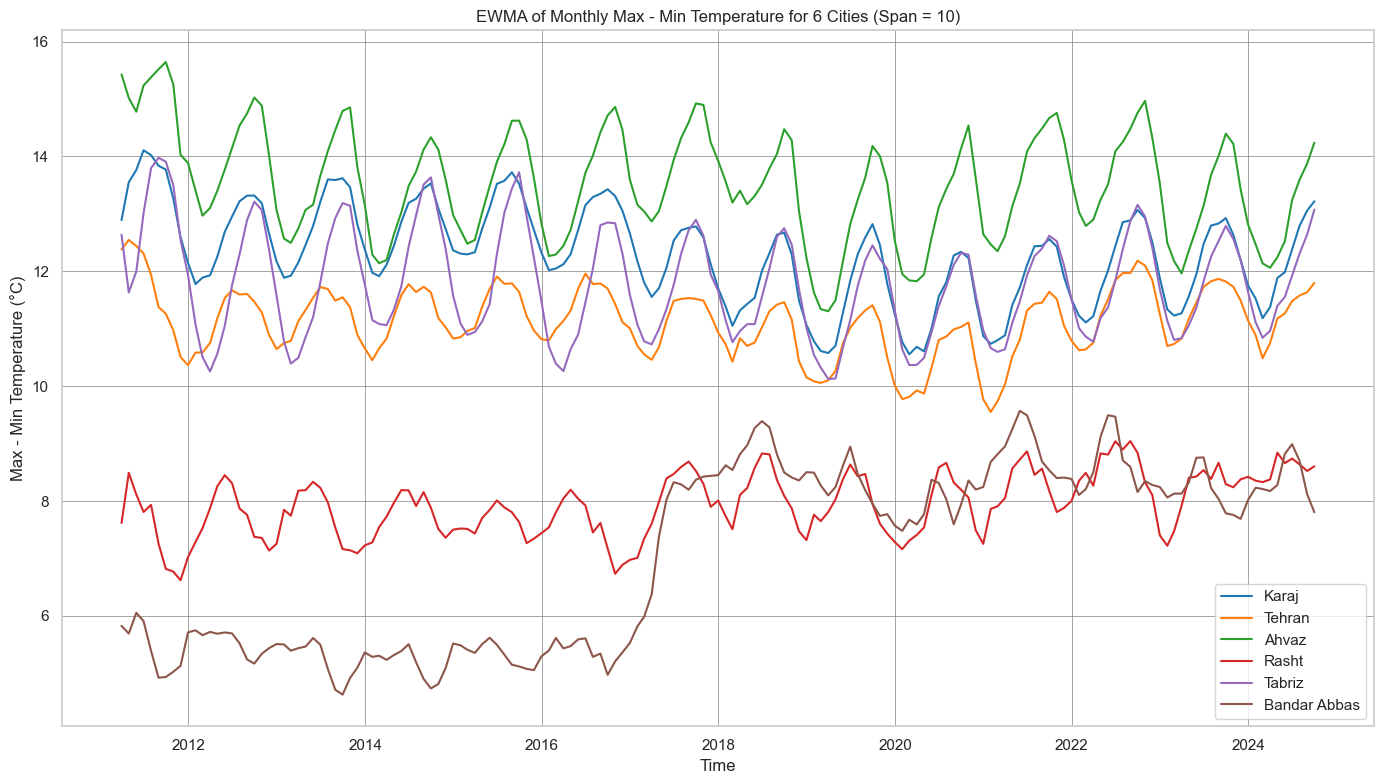

In [238]:
important_cities = ['Karaj', 'Tehran', 'Ahvaz', 'Rasht', 'Tabriz', 'Bandar Abbas']
filtered_data = df[df['city'].isin(important_cities)]
span = 10
pallet = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9569bd', '#8c564b']

plt.figure(figsize=(14, 8))

for idx, city in enumerate(important_cities):
    city_data = filtered_data[filtered_data['city'] == city]
    city_monthly = city_data.resample('ME', on='date_gregorian').mean(numeric_only=True)
    ewma_max_minus_min = city_monthly['temp_diff (°C)'].ewm(span=span).mean()
    plt.plot(ewma_max_minus_min.index, ewma_max_minus_min, label=city, color=pallet[idx])

plt.title(f"EWMA of Monthly Max - Min Temperature for {len(important_cities)} Cities (Span = {span})")
plt.xlabel("Time")
plt.ylabel("Max - Min Temperature (°C)")
plt.legend()
plt.grid(True, color='gray', linewidth=0.5)  
plt.tight_layout()
plt.show()

del important_cities, filtered_data, pallet, span, city_data, city_monthly, ewma_max_minus_min

#### Temperature Distance : Seasonal Analysis

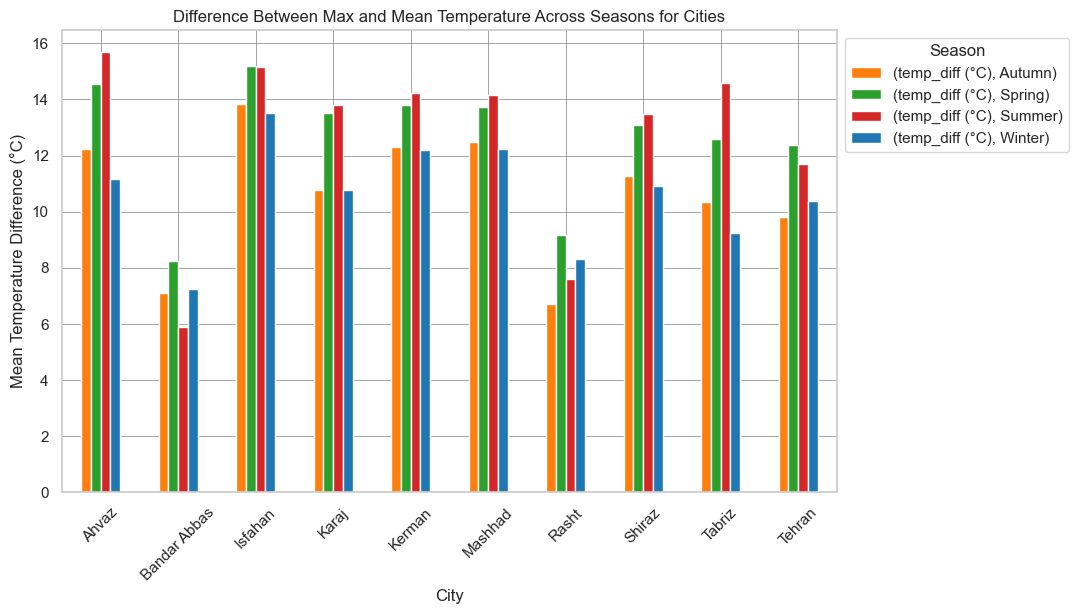

In [239]:
city_season_trends = df.groupby(['city', 'season']).agg({
    'temp_diff (°C)': 'mean',
}).unstack()
pallet = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4']

ax = city_season_trends.plot(kind='bar', figsize=(10, 6), color=pallet)

plt.title("Difference Between Max and Mean Temperature Across Seasons for Cities")
plt.xlabel("City")
plt.ylabel("Mean Temperature Difference (°C)")
plt.xticks(rotation=0)
plt.legend(title="Season", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 
plt.xticks(rotation=45)
plt.show()

del city_season_trends, pallet, ax

### Temperature Box Plot Relationships

#### Temperature Distance : Monthly Analysis

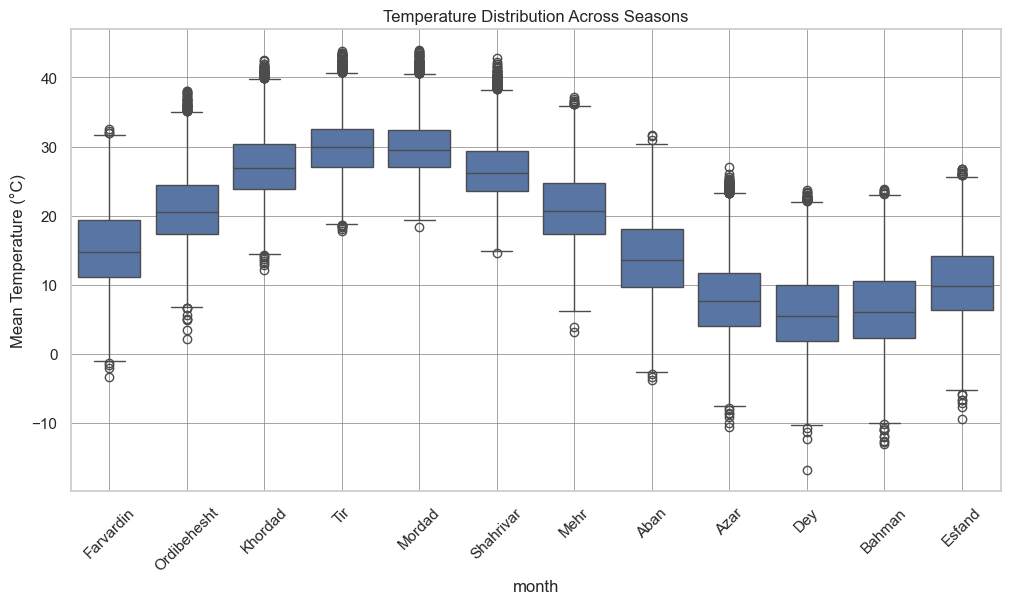

In [240]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp_mean (°C)', data=df)
plt.title("Temperature Distribution Across Seasons")
plt.ylabel("Mean Temperature (°C)")
plt.grid(True, color='gray', linewidth=0.5) 
plt.xticks(rotation=45)
plt.show()

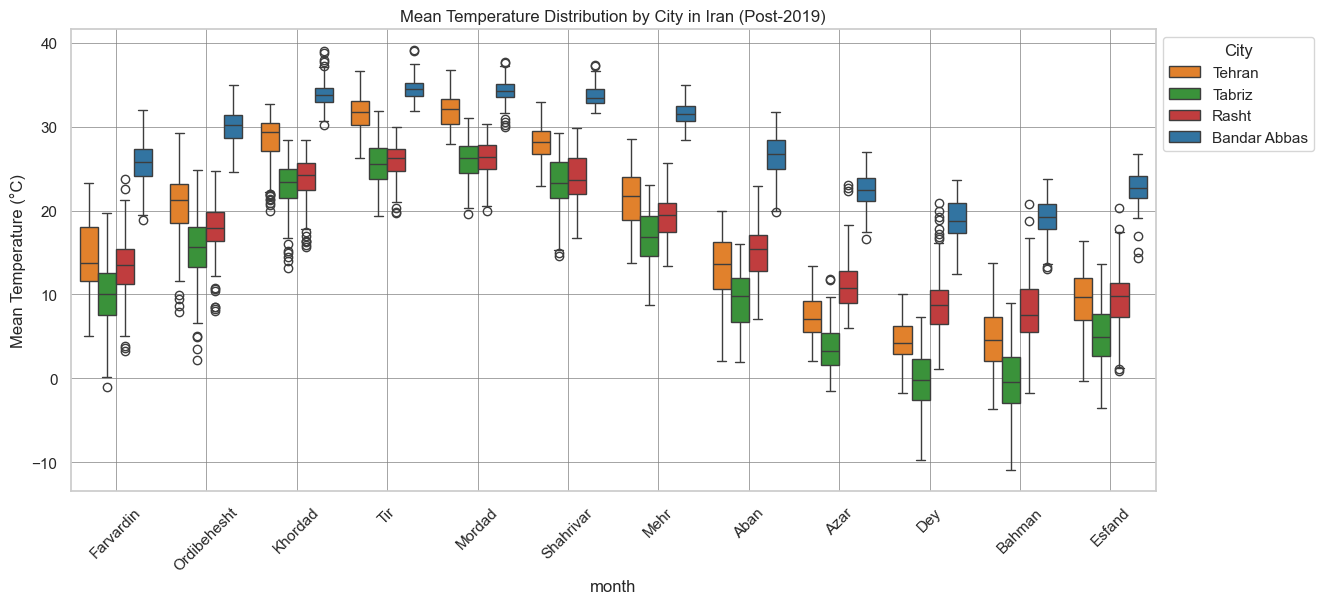

In [241]:
filtered_cities = ['Tehran', 'Rasht', 'Tabriz', 'Bandar Abbas']
filtered_data = df[(df['city'].isin(filtered_cities)) & (df['date_gregorian'] > '2019-03-21')]

plt.figure(figsize=(14, 6))

palette = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4']
sns.set_palette(palette)

sns.boxplot(x='month', y='temp_mean (°C)', hue='city', data=filtered_data)
plt.title("Mean Temperature Distribution by City in Iran (Post-2019)")
plt.ylabel("Mean Temperature (°C)")
plt.legend(title='City', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 
plt.xticks(rotation=45)
plt.show()

del filtered_cities, filtered_data, palette

#### Temperature Distance : Seasonal Analysis

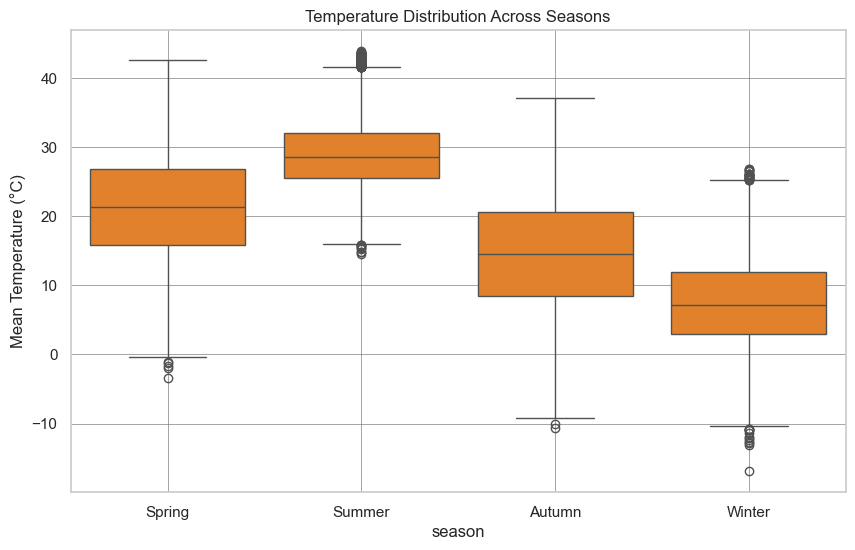

In [242]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='temp_mean (°C)', data=df)
plt.title("Temperature Distribution Across Seasons")
plt.ylabel("Mean Temperature (°C)")
plt.grid(True, color='gray', linewidth=0.5) 
plt.show()

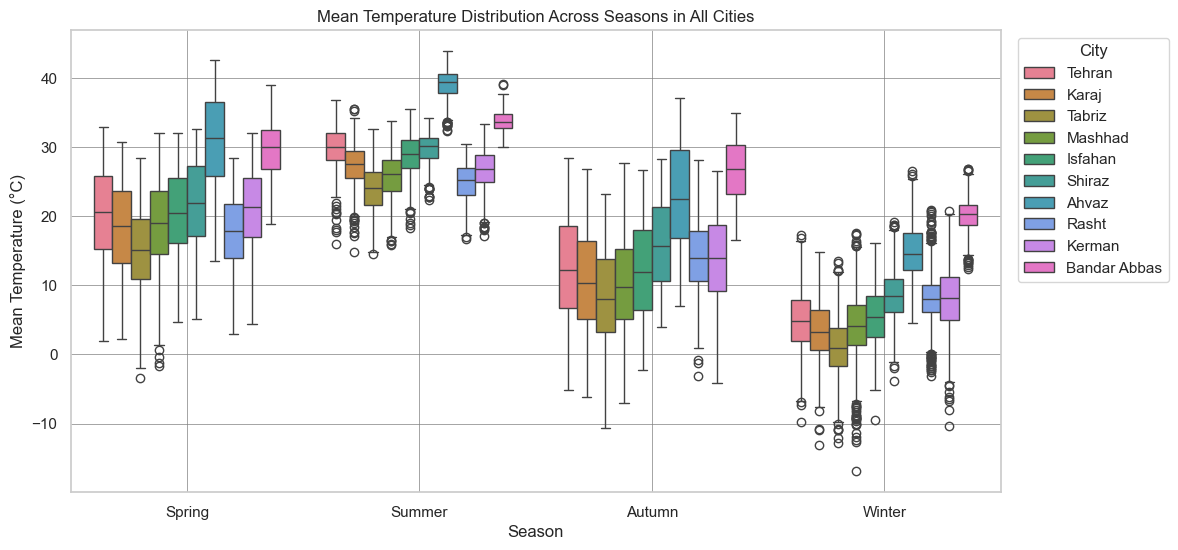

In [243]:
plt.figure(figsize=(12, 6))
sns.set_palette('rainbow')
sns.boxplot(x='season', y='temp_mean (°C)', hue='city', data=df)
plt.title("Mean Temperature Distribution Across Seasons in All Cities")
plt.ylabel("Mean Temperature (°C)")
plt.xlabel("Season")
plt.legend(title='City', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 
plt.show()

### City-Wise Temperature Correlation

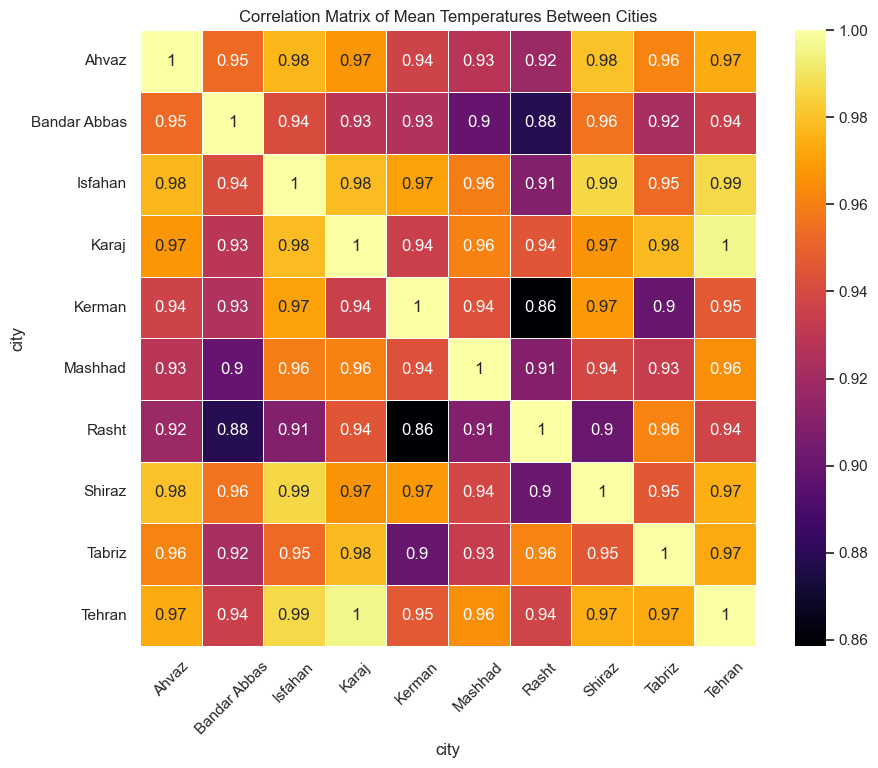

In [244]:
df_filtered = df[df['date_gregorian'] > '2019-03-21']
df_pivot = df_filtered.pivot_table(index='date_gregorian', columns='city', values='temp_mean (°C)')
correlation_matrix = df_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="inferno", linewidths=0.5, square=True)
plt.title('Correlation Matrix of Mean Temperatures Between Cities')
plt.xticks(rotation=45)
plt.show()

del correlation_matrix, df_filtered, df_pivot

## Precipitation Analysis

#### City-Wise Analysis

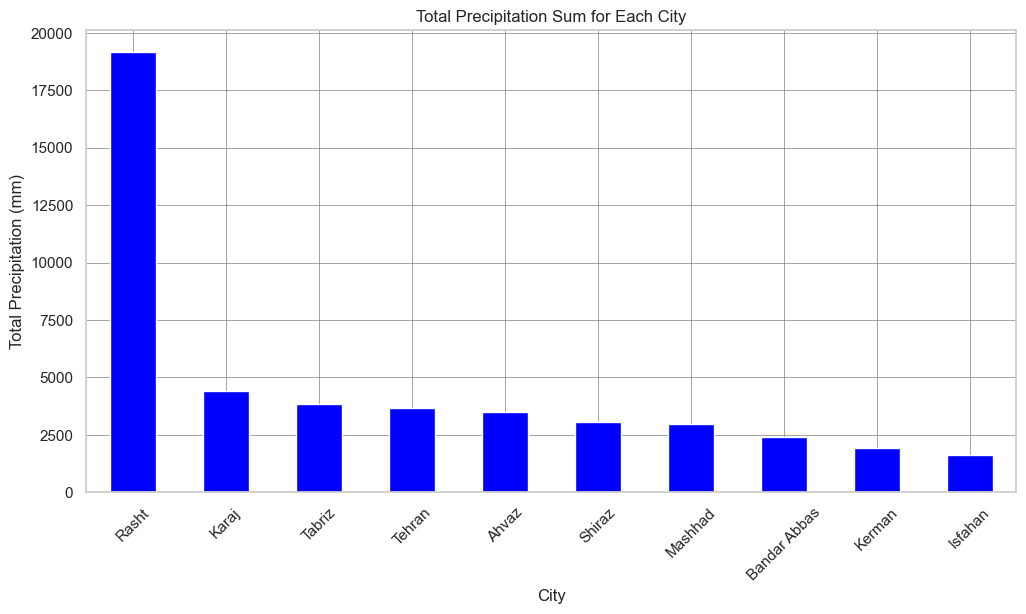

In [245]:
city_precip = df.groupby('city')['precipitation_sum (mm)'].sum().sort_values(ascending=False)
city_precip.plot(kind='bar', figsize=(12, 6), color='blue')
plt.title("Total Precipitation Sum for Each City")
plt.ylabel("Total Precipitation (mm)")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.grid(True, color='gray', linewidth=0.5) 
plt.show()

del city_precip

#### Analysis Based on Snow and Rain

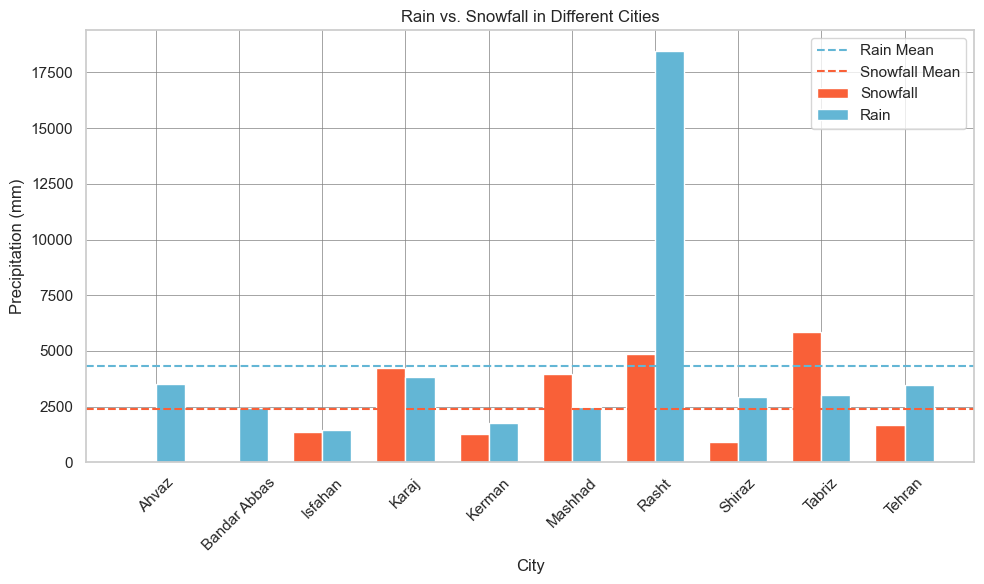

In [246]:
city_precip = df.groupby('city')[['rain_sum (mm)', 'snowfall_sum (mm)']].sum()
bar_width = 0.35
x = range(len(city_precip))
plt.figure(figsize=(10, 6))

plt.bar(x, city_precip['snowfall_sum (mm)'], width=bar_width, label='Snowfall', color='#f96038')
plt.bar([p + bar_width for p in x], city_precip['rain_sum (mm)'], width=bar_width, label='Rain', color='#63b6d5')

rainfall_mean = city_precip['rain_sum (mm)'].mean()
snowfall_mean = city_precip['snowfall_sum (mm)'].mean()

plt.axhline(y=rainfall_mean, color='#63b6d5', linestyle='--', label='Rain Mean')
plt.axhline(y=snowfall_mean, color='#f96038', linestyle='--', label='Snowfall Mean')

plt.title("Rain vs. Snowfall in Different Cities")
plt.ylabel("Precipitation (mm)")
plt.xlabel("City")
plt.xticks([p + bar_width / 2 for p in x], city_precip.index)  # Center the tick labels
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, color='gray', linewidth=0.5) 
plt.tight_layout()
plt.show()

del city_precip, bar_width, x, rainfall_mean, snowfall_mean

#### City-Wise Seasonal Analysis

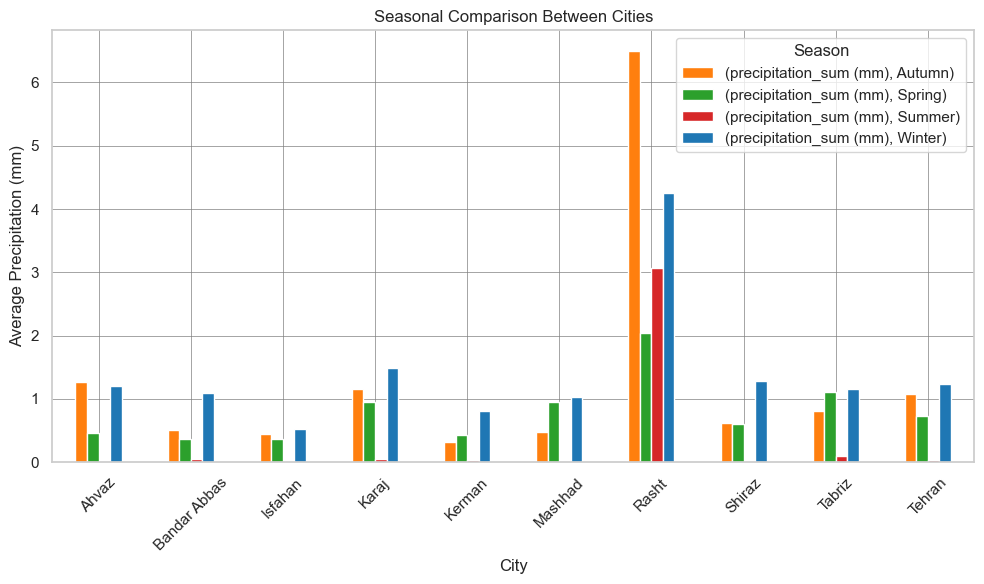

In [247]:
city_season_trends = df.groupby(['city', 'season']).agg({
    'precipitation_sum (mm)': 'mean',
}).unstack()
pallet = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4']

ax = city_season_trends.plot(kind='bar', figsize=(10, 6), title="Seasonal Comparison Between Cities", color=pallet)
ax.set_xlabel("City")
ax.set_ylabel("Average Precipitation (mm)")
ax.legend(title="Season")
plt.xticks(rotation=45)
plt.grid(True, color='gray', linewidth=0.5) 
plt.tight_layout()
plt.show()

### Evapotranspiration Analysis

#### Date-wise Analysis

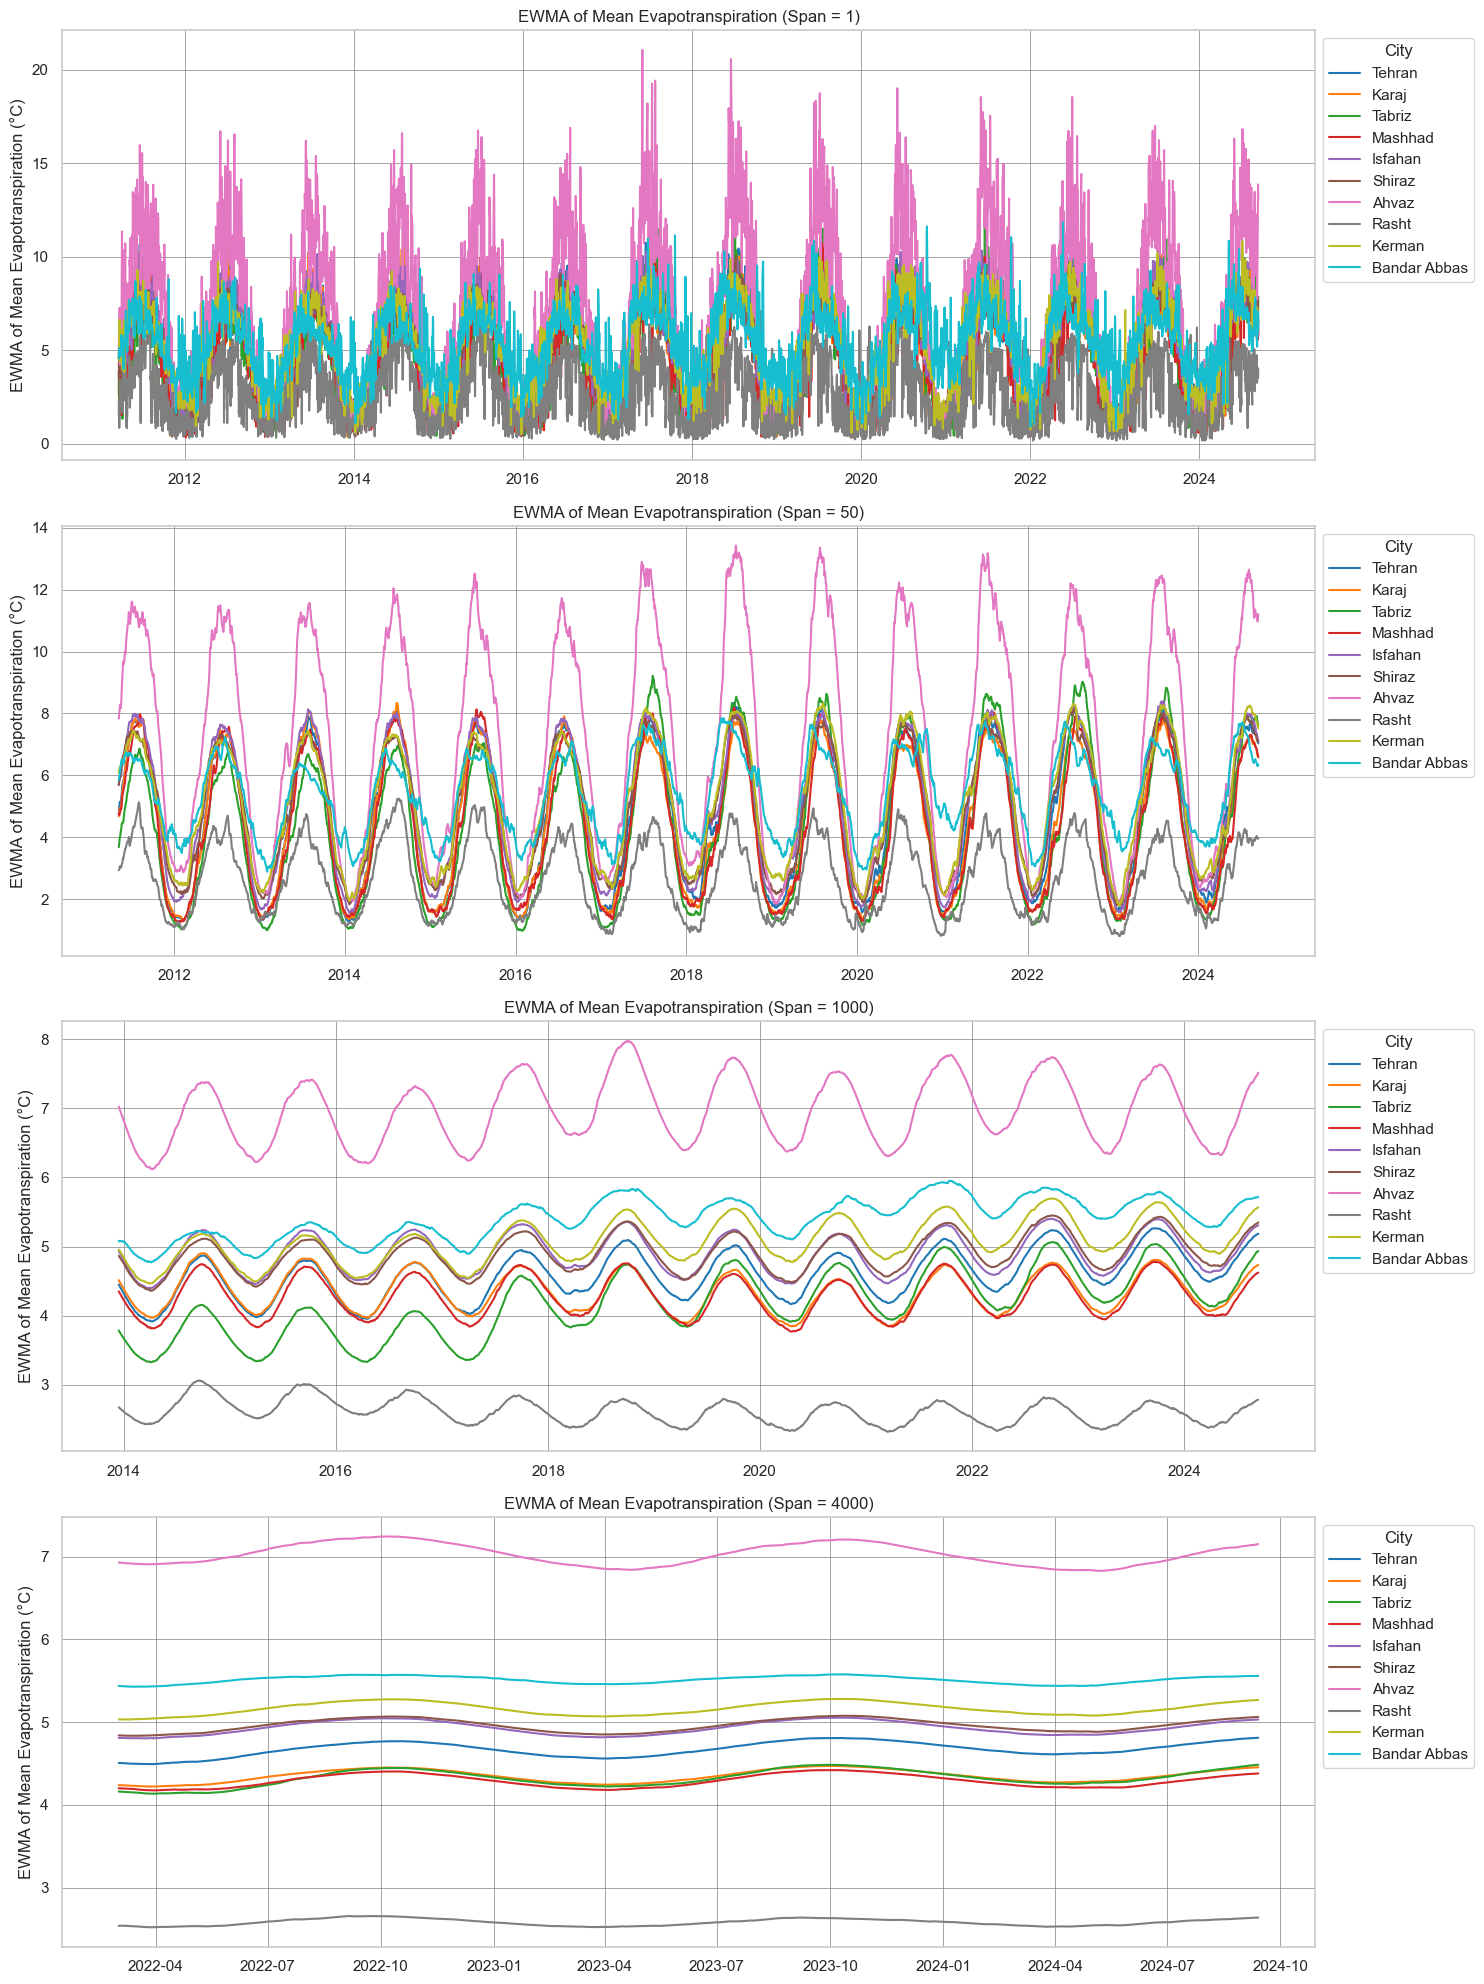

In [248]:
spans = [1, 50, 1000, 4000]
pallet = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig, axs = plt.subplots(len(spans), 1, figsize=(15, 20))
cities = df['city'].unique()

for i, span in enumerate(spans):
    for j, city in enumerate(cities):
        city_data = df[df['city'] == city].set_index('date_gregorian')
        ewma_evap = city_data['evapotranspiration (mm)'].ewm(span=span).mean()
        
        # Determine the starting point for plotting
        start_index = ewma_evap.index[span - 1]
        axs[i].plot(ewma_evap.index[span - 1:], ewma_evap[span - 1:], label=city, color=pallet[j % len(pallet)])

    axs[i].set_title(f"EWMA of Mean Evapotranspiration (Span = {spans[i]})")
    axs[i].set_ylabel("EWMA of Mean Evapotranspiration (°C)")
    axs[i].legend(title="City", bbox_to_anchor=(1, 1), loc='upper left')
    axs[i].grid(True, color='gray', linewidth=0.5) 

plt.tight_layout()
plt.show()

del spans, pallet, fig, axs, cities, city_data, ewma_evap

#### City-Wise Analysis

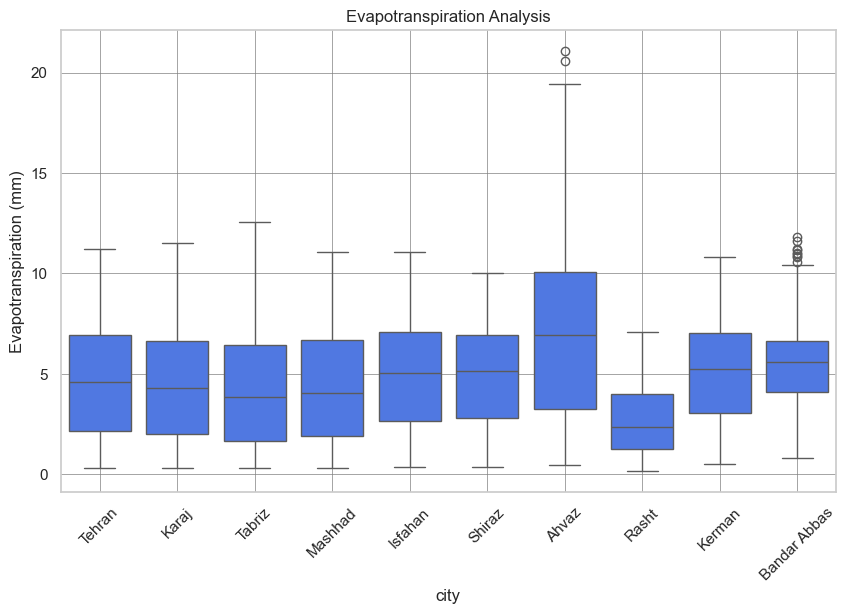

In [249]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='evapotranspiration (mm)', data=df)
plt.title("Evapotranspiration Analysis")
plt.ylabel("Evapotranspiration (mm)")
plt.grid(True, color='gray', linewidth=0.5) 
plt.xticks(rotation=45)
plt.show()

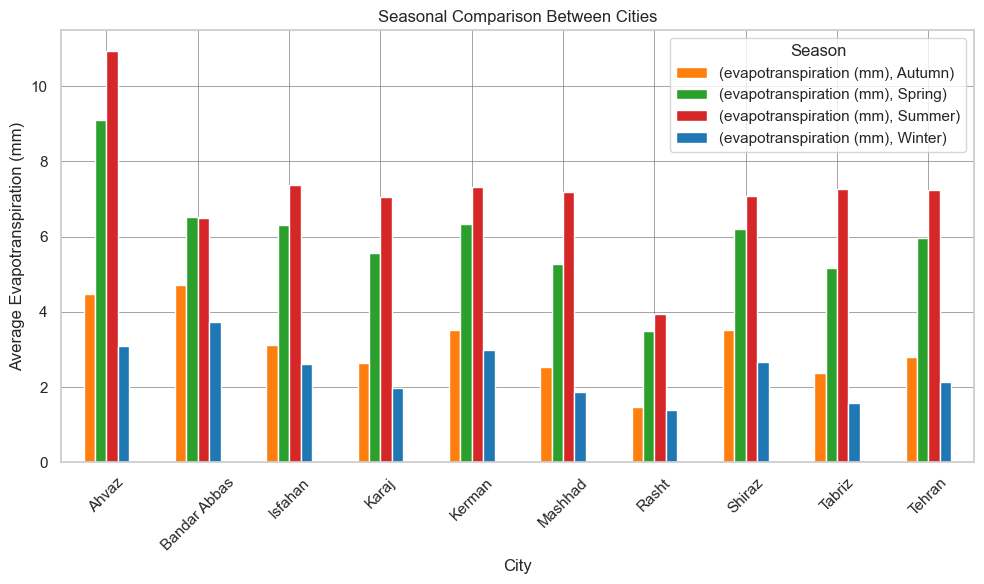

In [250]:
city_season_trends = df.groupby(['city', 'season']).agg({
    'evapotranspiration (mm)': 'mean',
}).unstack()
pallet = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4']

ax = city_season_trends.plot(kind='bar', figsize=(10, 6), title="Seasonal Comparison Between Cities", color=pallet)
ax.set_xlabel("City")
ax.set_ylabel("Average Evapotranspiration (mm)")
ax.legend(title="Season")
plt.xticks(rotation=45)
plt.grid(True, color='gray', linewidth=0.5) 
plt.tight_layout()
plt.show()

del city_season_trends

### Evapotranspiration vs Shortwave Radiation

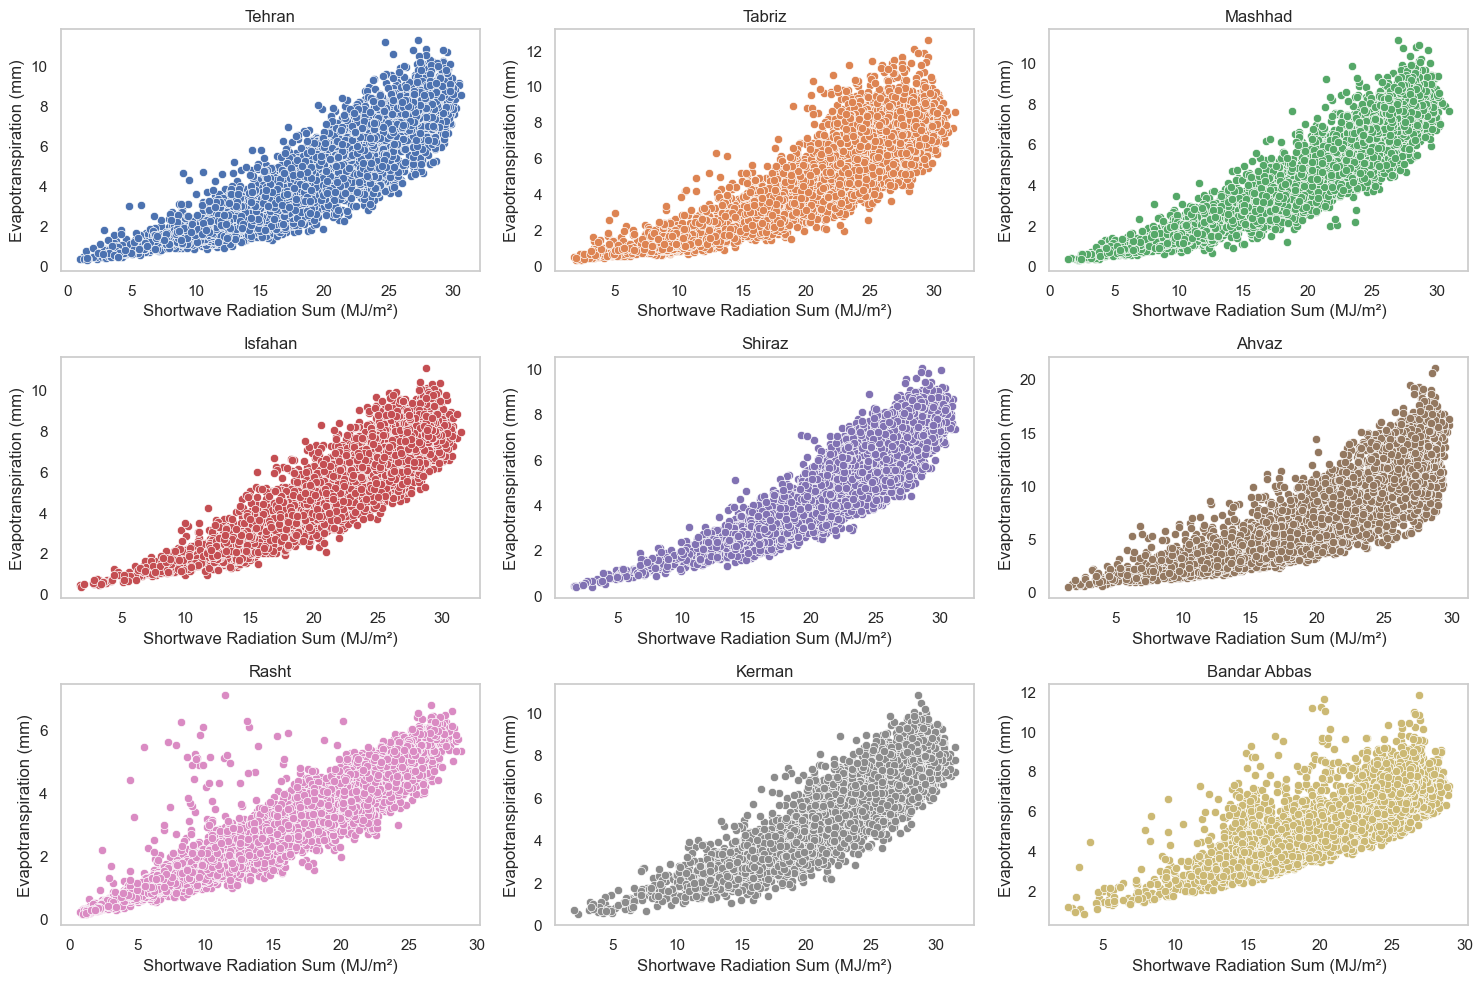

In [251]:

filtered_df = df[df['city'] != 'Karaj']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten() 
cities = filtered_df['city'].unique()

for i, city in enumerate(cities):
    subset = filtered_df[filtered_df['city'] == city]
    sns.scatterplot(data=subset, x='shortwave_radiation_sum (MJ/m²)', y='evapotranspiration (mm)', ax=axes[i], color=sns.color_palette('deep')[i])
    axes[i].set_title(city)
    axes[i].set_xlabel('Shortwave Radiation Sum (MJ/m²)')
    axes[i].set_ylabel('Evapotranspiration (mm)')
    axes[i].grid()

plt.tight_layout()
plt.show()

del filtered_df, fig, axes, cities, subset

### Precipitation and Evapotranspiration Difference Analysis

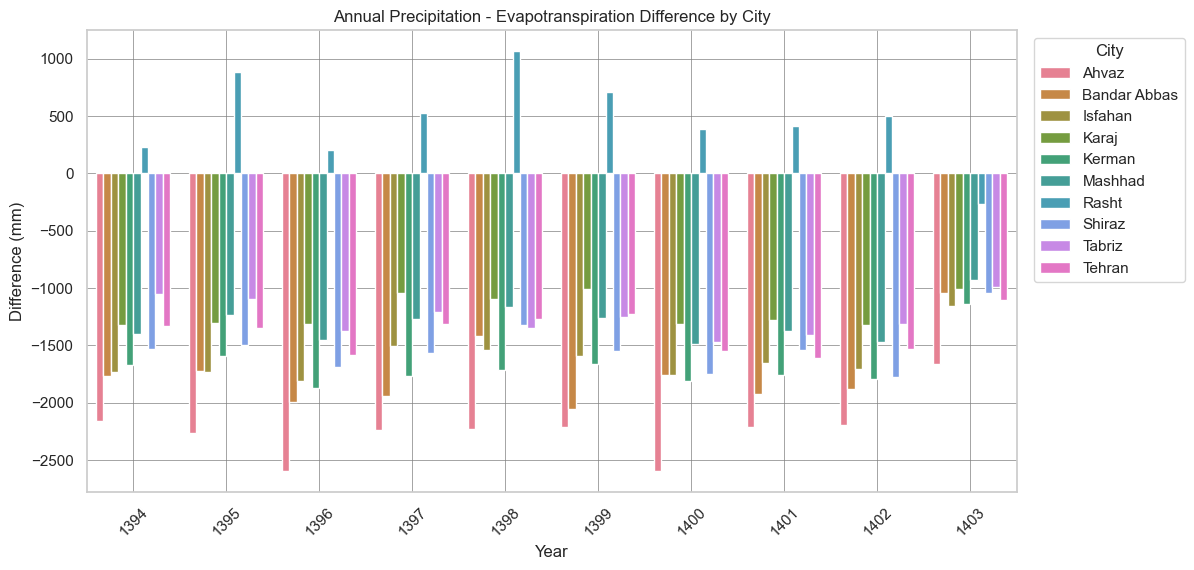

In [252]:
annual_diff = df.groupby(['year', 'city'])['remain_precipitation (mm)'].sum().reset_index()
annual_diff = annual_diff[annual_diff['year'] >= 1394]

plt.figure(figsize=(12, 6))
sns.set_palette('rainbow')
sns.barplot(data=annual_diff, x='year', y='remain_precipitation (mm)', hue='city')
plt.title("Annual Precipitation - Evapotranspiration Difference by City")
plt.xlabel("Year")
plt.ylabel("Difference (mm)")
plt.xticks(rotation=45)
plt.legend(title='City', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 
plt.show()

del annual_diff

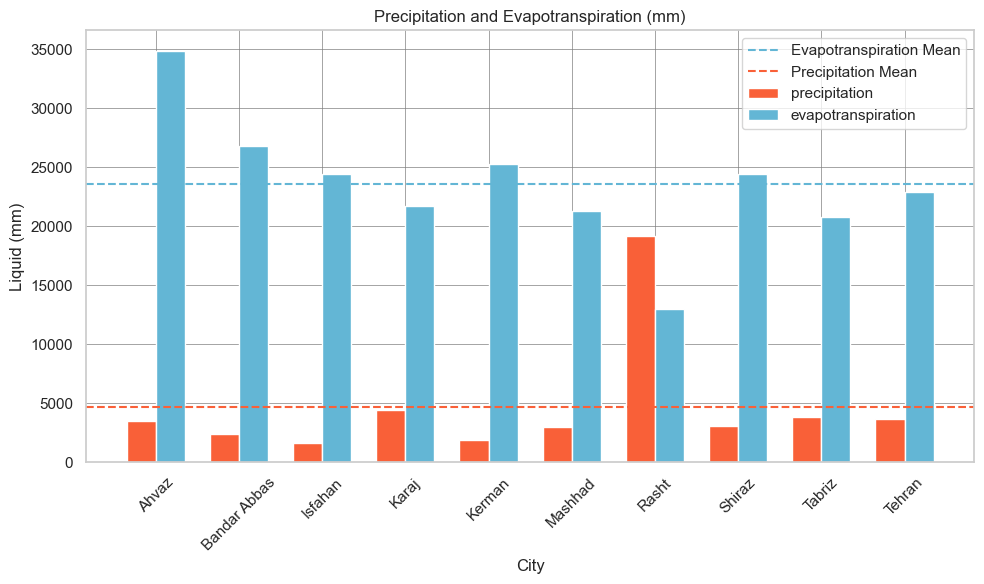

In [253]:
city_precip = df.groupby('city')[['precipitation_sum (mm)', 'evapotranspiration (mm)']].sum()
bar_width = 0.35
x = range(len(city_precip))
plt.figure(figsize=(10, 6))

plt.bar(x, city_precip['precipitation_sum (mm)'], width=bar_width, label='precipitation', color='#f96038')
plt.bar([p + bar_width for p in x], city_precip['evapotranspiration (mm)'], width=bar_width, label='evapotranspiration', color='#63b6d5')

rainfall_mean = city_precip['evapotranspiration (mm)'].mean()
snowfall_mean = city_precip['precipitation_sum (mm)'].mean()

plt.axhline(y=rainfall_mean, color='#63b6d5', linestyle='--', label='Evapotranspiration Mean')
plt.axhline(y=snowfall_mean, color='#f96038', linestyle='--', label='Precipitation Mean')

plt.title("Precipitation and Evapotranspiration (mm)")
plt.ylabel("Liquid (mm)")
plt.xlabel("City")
plt.xticks([p + bar_width / 2 for p in x], city_precip.index)  # Center the tick labels
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, color='gray', linewidth=0.5) 
plt.tight_layout()
plt.show()

del city_precip, bar_width, rainfall_mean, snowfall_mean

### Precipitation Hour Analysis

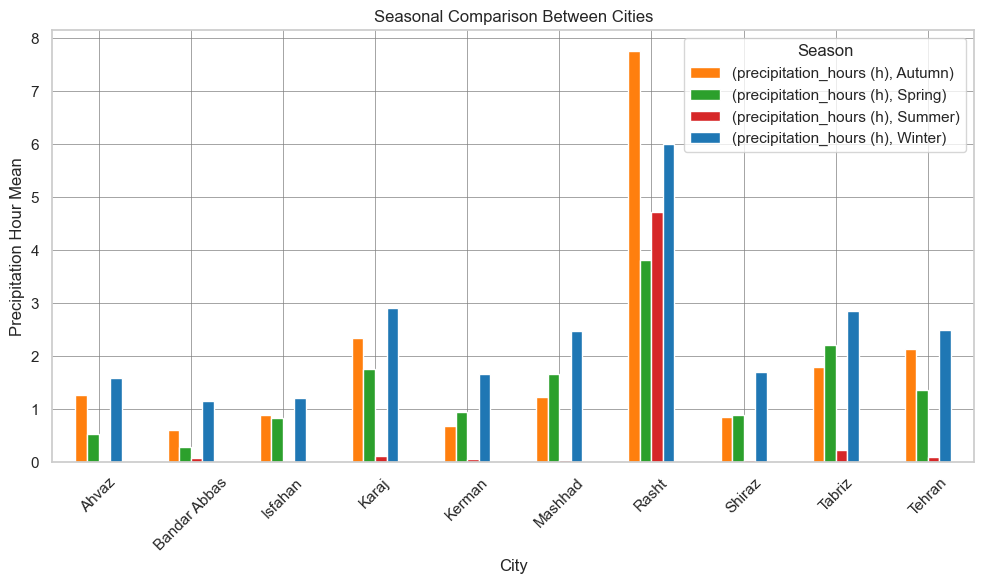

In [254]:
city_season_trends = df.groupby(['city', 'season']).agg({
    'precipitation_hours (h)': 'mean',
}).unstack()
pallet = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4']

ax = city_season_trends.plot(kind='bar', figsize=(10, 6), title="Seasonal Comparison Between Cities", color=pallet)
ax.set_xlabel("City")
ax.set_ylabel("Precipitation Hour Mean")
ax.legend(title="Season")
plt.xticks(rotation=45)
plt.grid(True, color='gray', linewidth=0.5) 
plt.tight_layout()
plt.show()

del city_season_trends

### Precipitation Correlation

#### City-Wise Precipitation

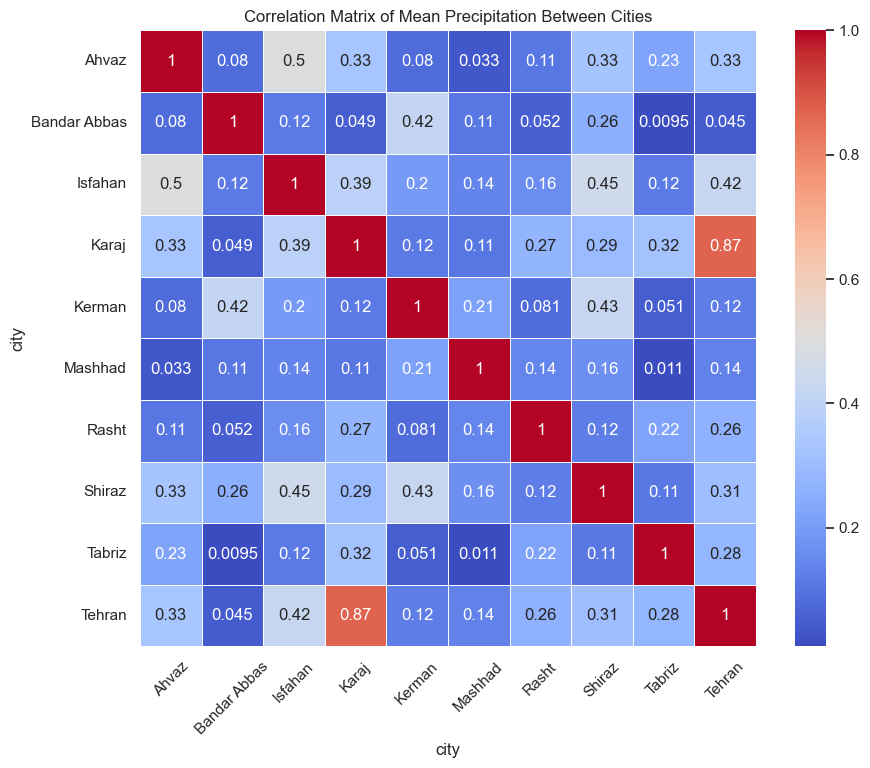

In [255]:
df_pivot = df.pivot_table(index='date_gregorian', columns='city', values='precipitation_sum (mm)')
correlation_matrix = df_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, square=True)
plt.title('Correlation Matrix of Mean Precipitation Between Cities')
plt.xticks(rotation=45)
plt.show()

del correlation_matrix, df_pivot

#### City-Wise Evapotranspiration

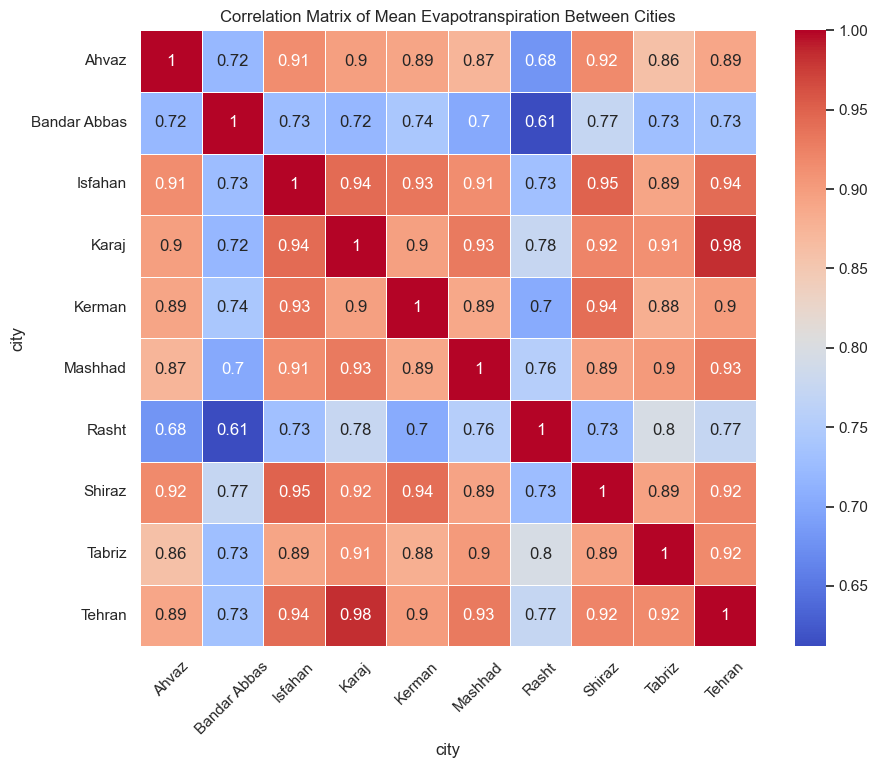

In [256]:
df_pivot = df.pivot_table(index='date_gregorian', columns='city', values='evapotranspiration (mm)')
correlation_matrix = df_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, square=True)
plt.title('Correlation Matrix of Mean Evapotranspiration Between Cities')
plt.xticks(rotation=45)
plt.show()

del correlation_matrix, df_pivot

## Wind Speed & Direction Analysis

### City-Wise Wind Speed over Time

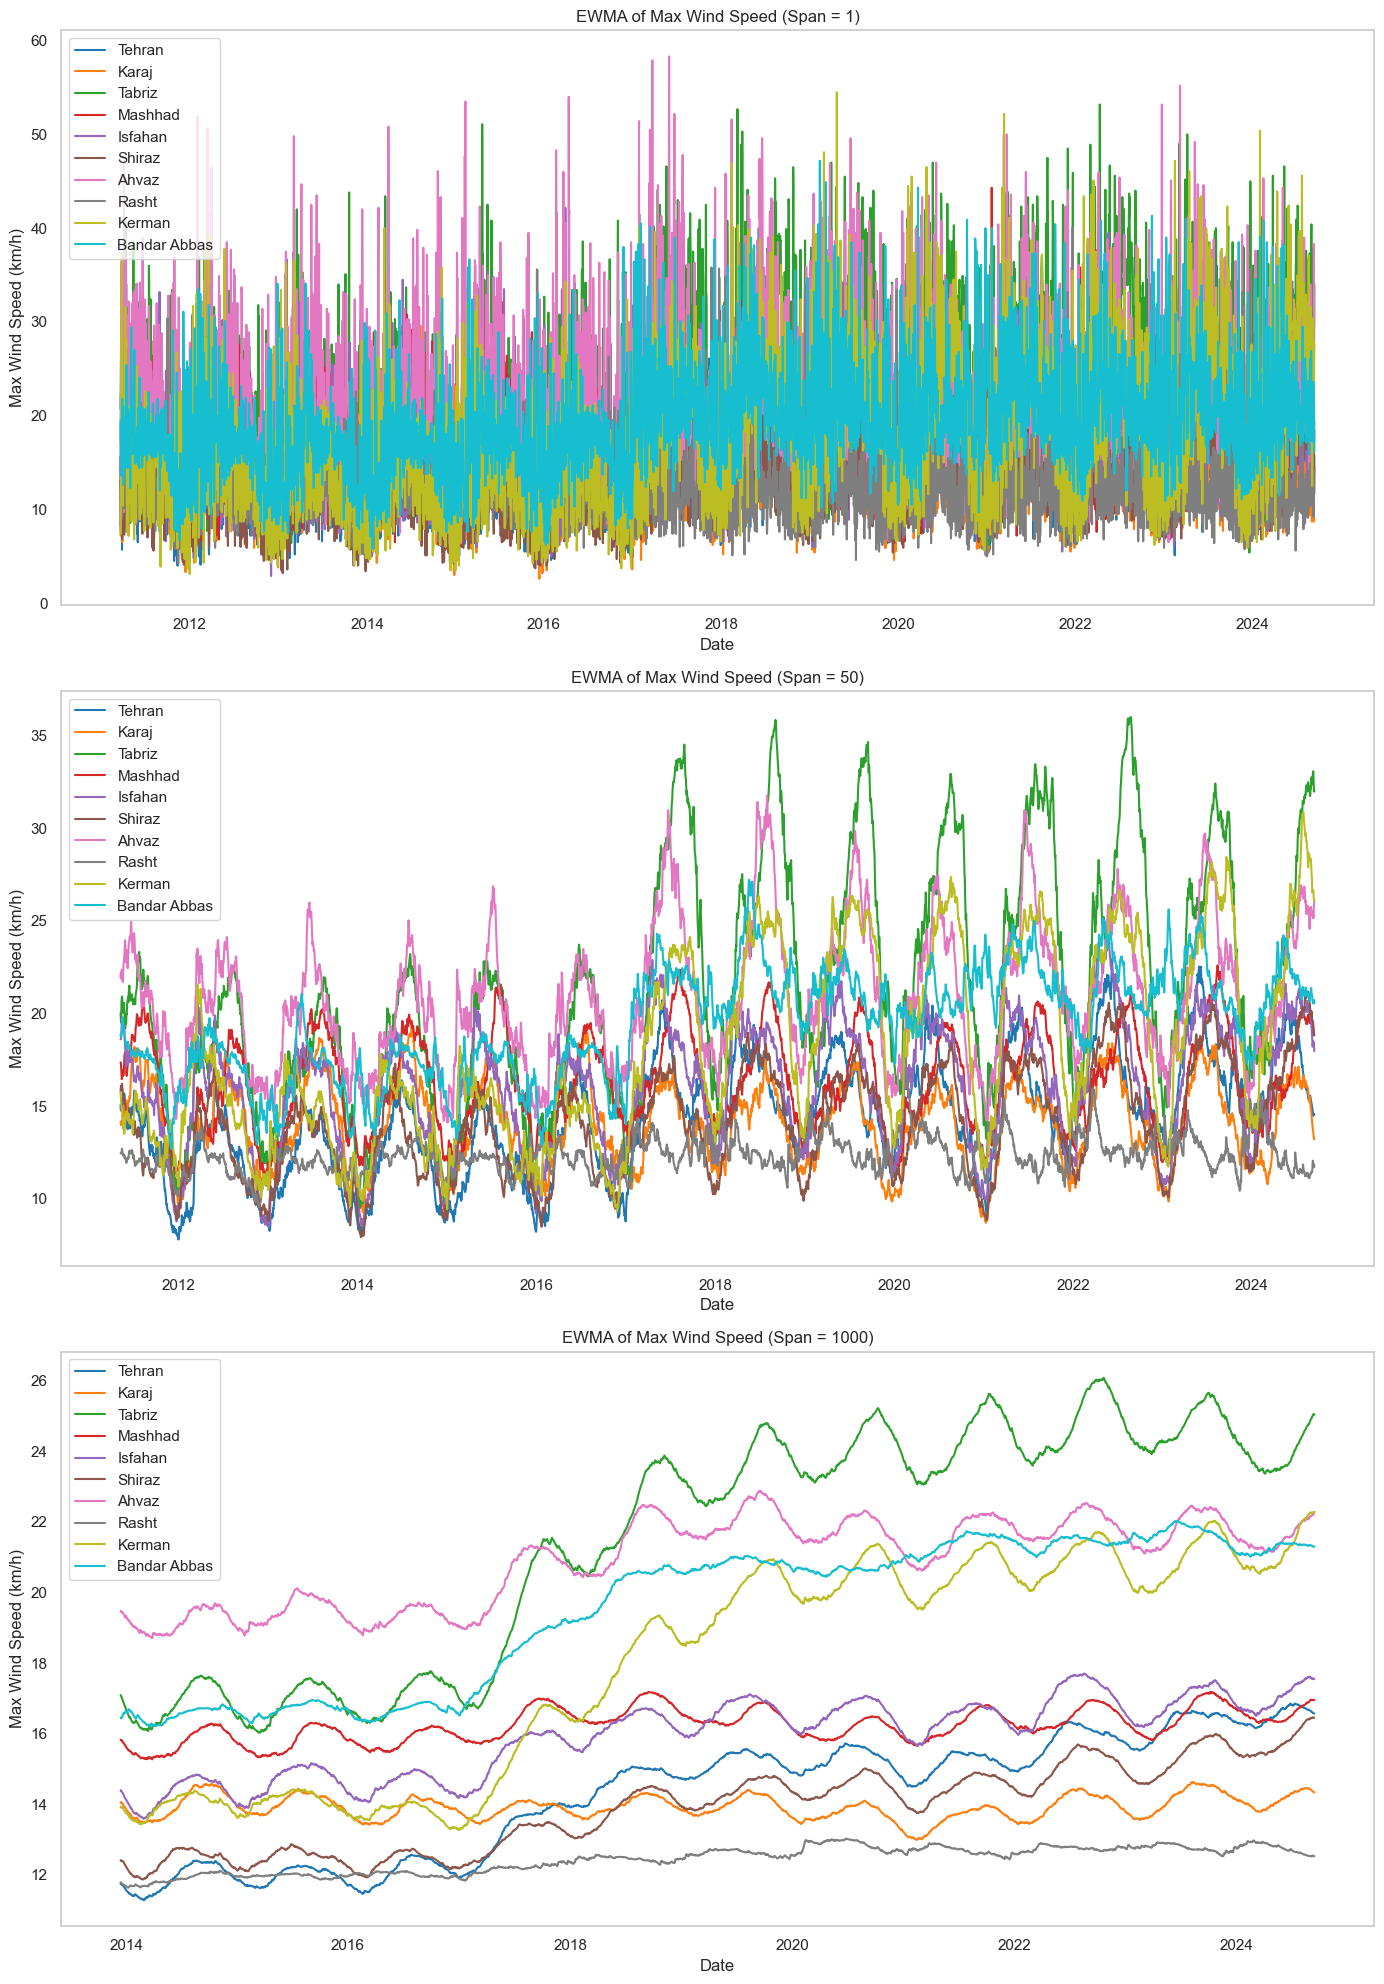

In [257]:
spans = [1, 50, 1000]

# Create a larger figure
fig, axs = plt.subplots(len(spans), 1, figsize=(14, 20))

# Define colors for the cities
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i, span in enumerate(spans):
    for j, city in enumerate(df['city'].unique()):
        # Calculate EWMA for each city
        cities = df[df['city'] == city].set_index('date_gregorian')
        ewma_wind_speed = cities['wind_speed_max (km/h)'].ewm(span=span).mean()

        # Determine the starting point for plotting
        start_index = ewma_wind_speed.index[span - 1]  # Adjust based on the span

        # Plot only from the starting index onward
        axs[i].plot(ewma_wind_speed.index[span - 1:], ewma_wind_speed[span - 1:], 
                    label=city, color=colors[j % len(colors)])  # Cycle through colors

    # Customize each subplot
    axs[i].set_title(f"EWMA of Max Wind Speed (Span = {spans[i]})")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Max Wind Speed (km/h)")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

### Wind Speed & Wind Gust Distribiutions

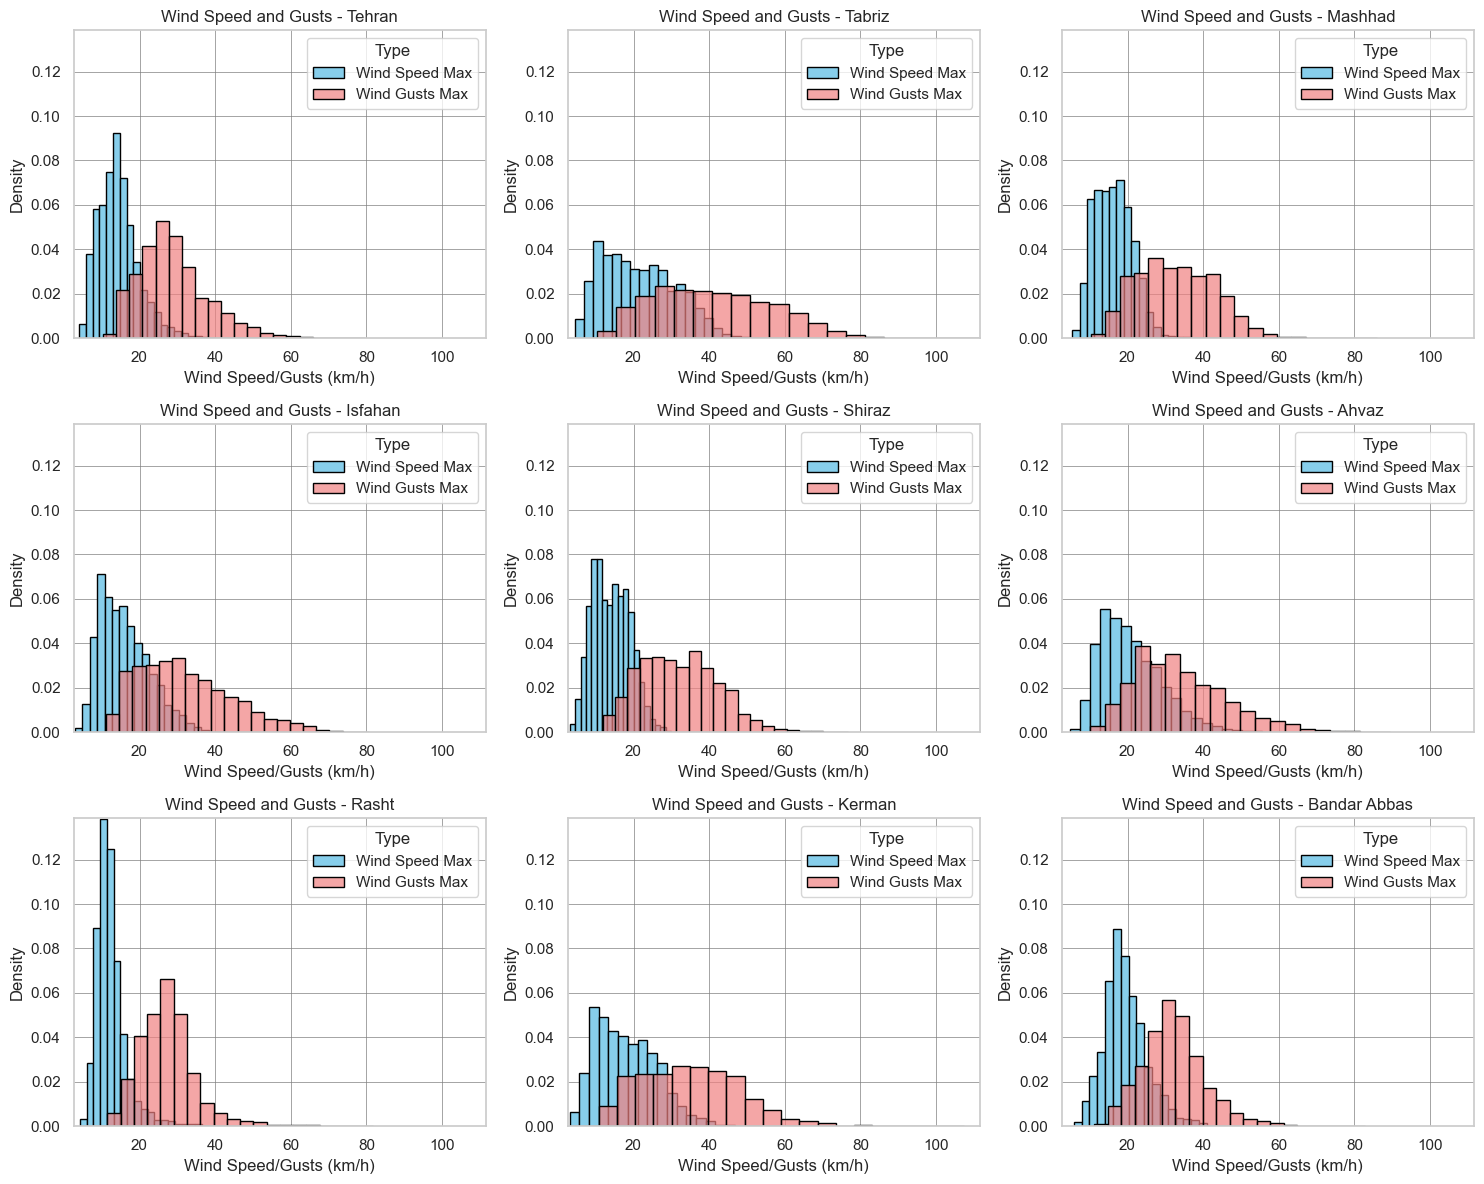

In [258]:
sns.set(style="whitegrid")
cities = [city for city in df['city'].unique() if city != 'Karaj']
plt.figure(figsize=(15, 12))

min_wind = df['wind_speed_max (km/h)'].min()
max_wind = df['wind_speed_max (km/h)'].max()
min_gust = df['wind_gusts_max (km/h)'].min()
max_gust = df['wind_gusts_max (km/h)'].max()

max_density = 0
for city in cities:
    city_data = df[df['city'] == city]
    wind_hist, _ = np.histogram(city_data['wind_speed_max (km/h)'], bins=20, density=True)
    gust_hist, _ = np.histogram(city_data['wind_gusts_max (km/h)'], bins=20, density=True)
    max_density = max(max_density, wind_hist.max(), gust_hist.max())

for i, city in enumerate(cities, 1):
    plt.subplot(3, 3, i)  # Adjust rows and columns as needed
    city_data = df[df['city'] == city]
    sns.histplot(city_data['wind_speed_max (km/h)'], bins=20, color='skyblue', edgecolor='black', label='Wind Speed Max', stat='density', alpha=1)
    sns.histplot(city_data['wind_gusts_max (km/h)'], bins=20, color='lightcoral', edgecolor='black', label='Wind Gusts Max', stat='density', alpha=0.7)

    plt.title(f'Wind Speed and Gusts - {city}')
    plt.xlabel('Wind Speed/Gusts (km/h)')
    plt.ylabel('Density')
    plt.legend(title='Type', loc='upper right')
    plt.grid(True, color='gray', linewidth=0.5) 
    plt.xlim((min(min_wind, min_gust), max(max_wind, max_gust)))
    plt.ylim(0, max_density)

plt.tight_layout()
plt.show()

del min_wind, max_wind, min_gust, max_gust, max_density, city_data, cities, 

### Wind Direction Visualization

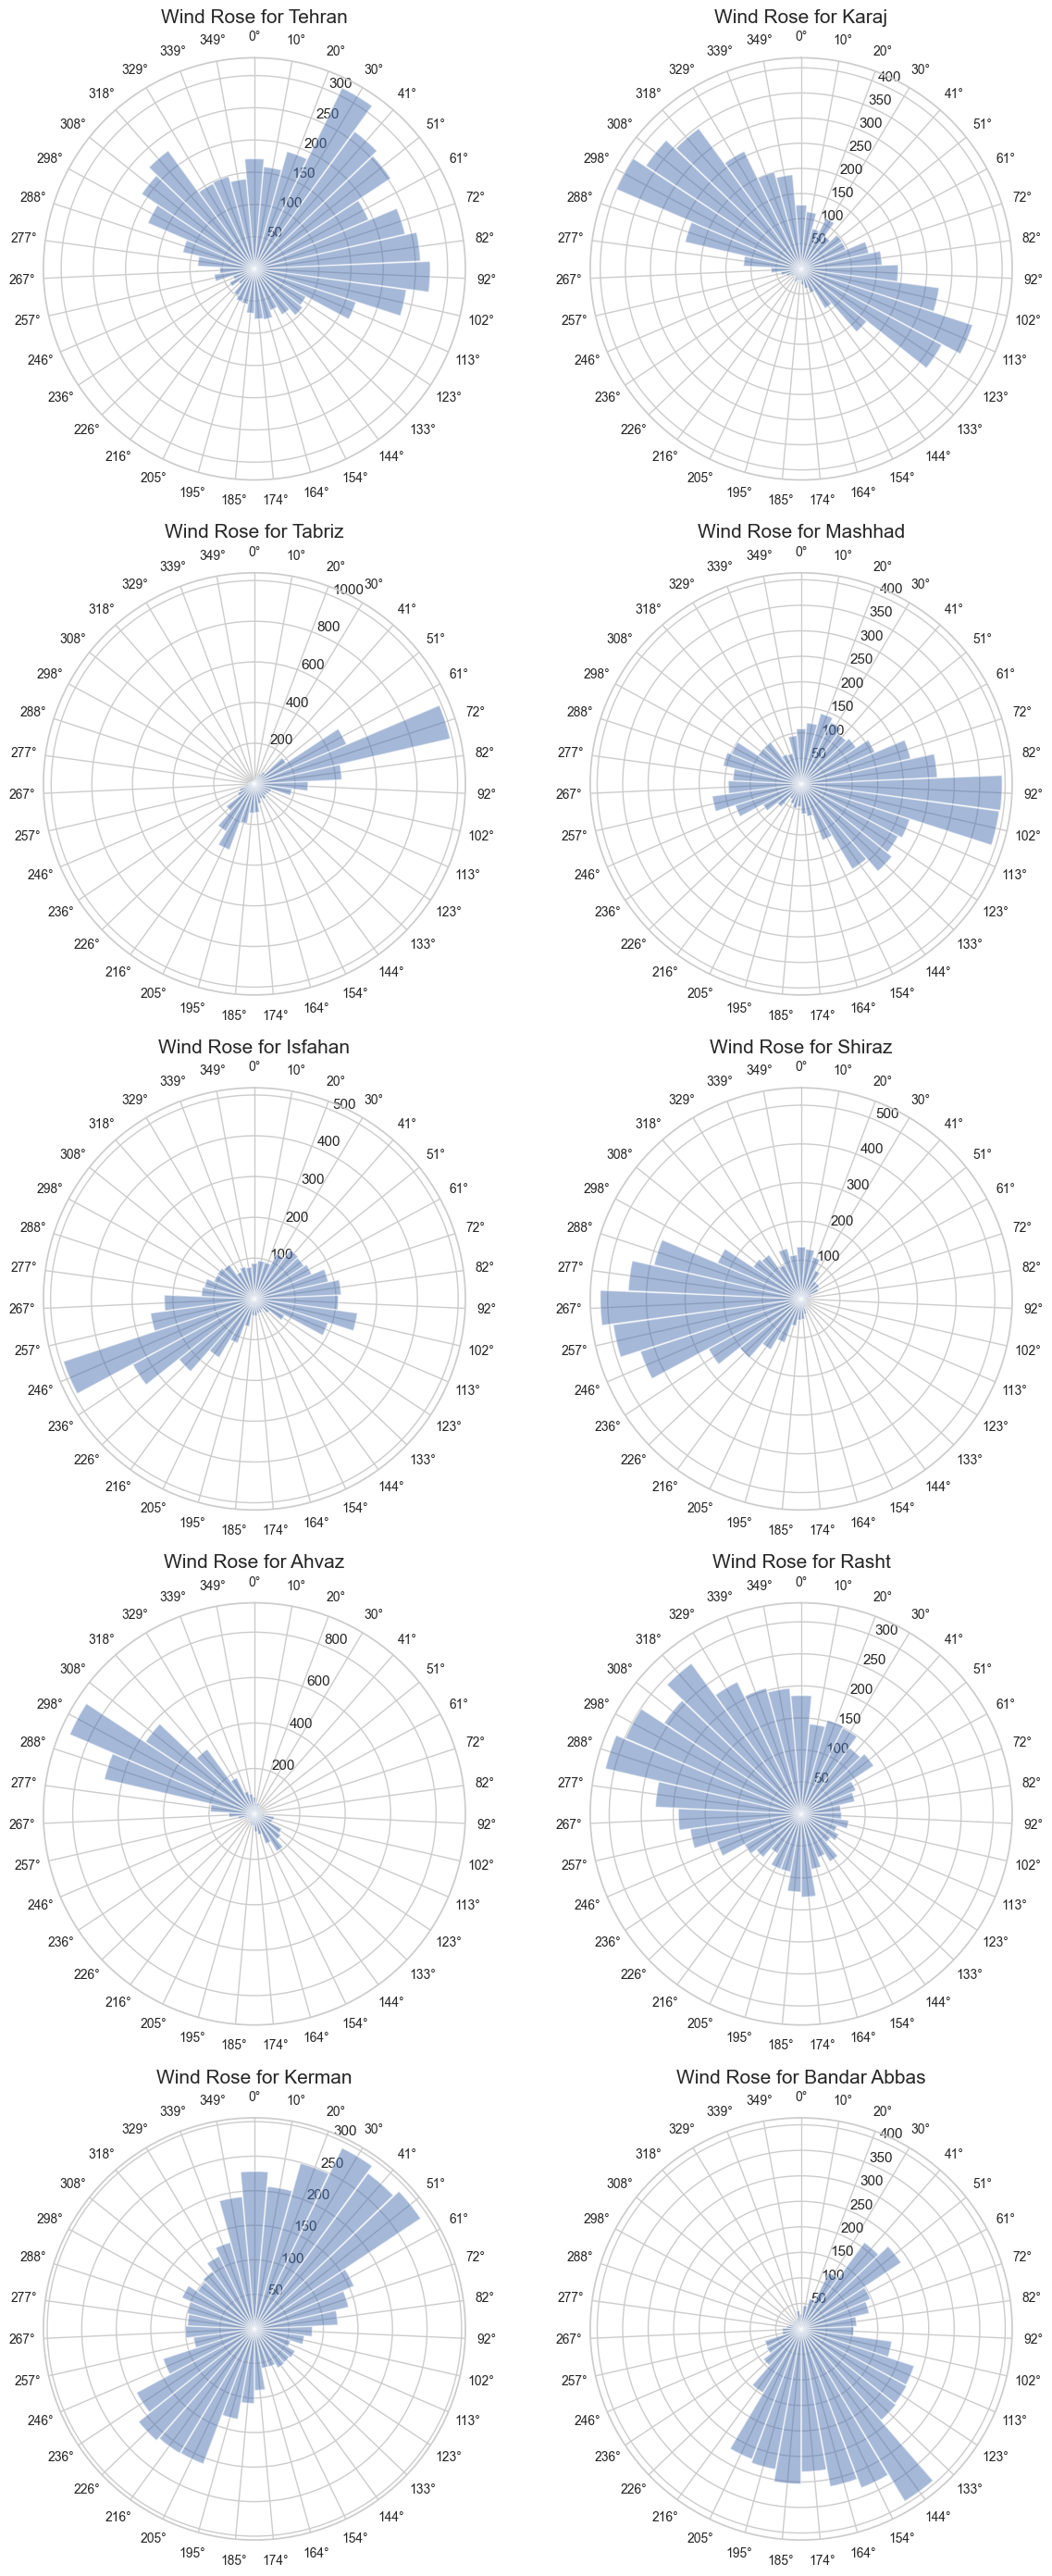

In [259]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 28), subplot_kw=dict(polar=True))
axs = axs.flatten()
cities = df['city'].unique()
bins = np.linspace(0, 360, num=36)  # 10° bins

for ax, city in zip(axs, cities):
    city_data = df[df['city'] == city]
    hist, _ = np.histogram(city_data['wind_direction_dominant (°)'], bins=bins)
    angles = np.deg2rad(bins[:-1])  # Convert to radians
    width = np.deg2rad(10)  # Width of each bin
    
    ax.set_theta_zero_location('N')  # Set 0 degrees at the top
    ax.set_theta_direction(-1)  # Clockwise direction
    ax.bar(angles, hist, width=width, bottom=0.0, alpha=0.5)

    ax.set_xticks(angles)
    ax.set_xticklabels([f"{int(b)}°" for b in bins[:-1]], fontsize=10)
    ax.set_title(f'Wind Rose for {city}', fontsize=15)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

del fig, axs, cities, city, ax, bins, city_data, hist, angles, width, 

### Wind Comparison with Other Parameters

#### Wind Speed vs Wind Gust

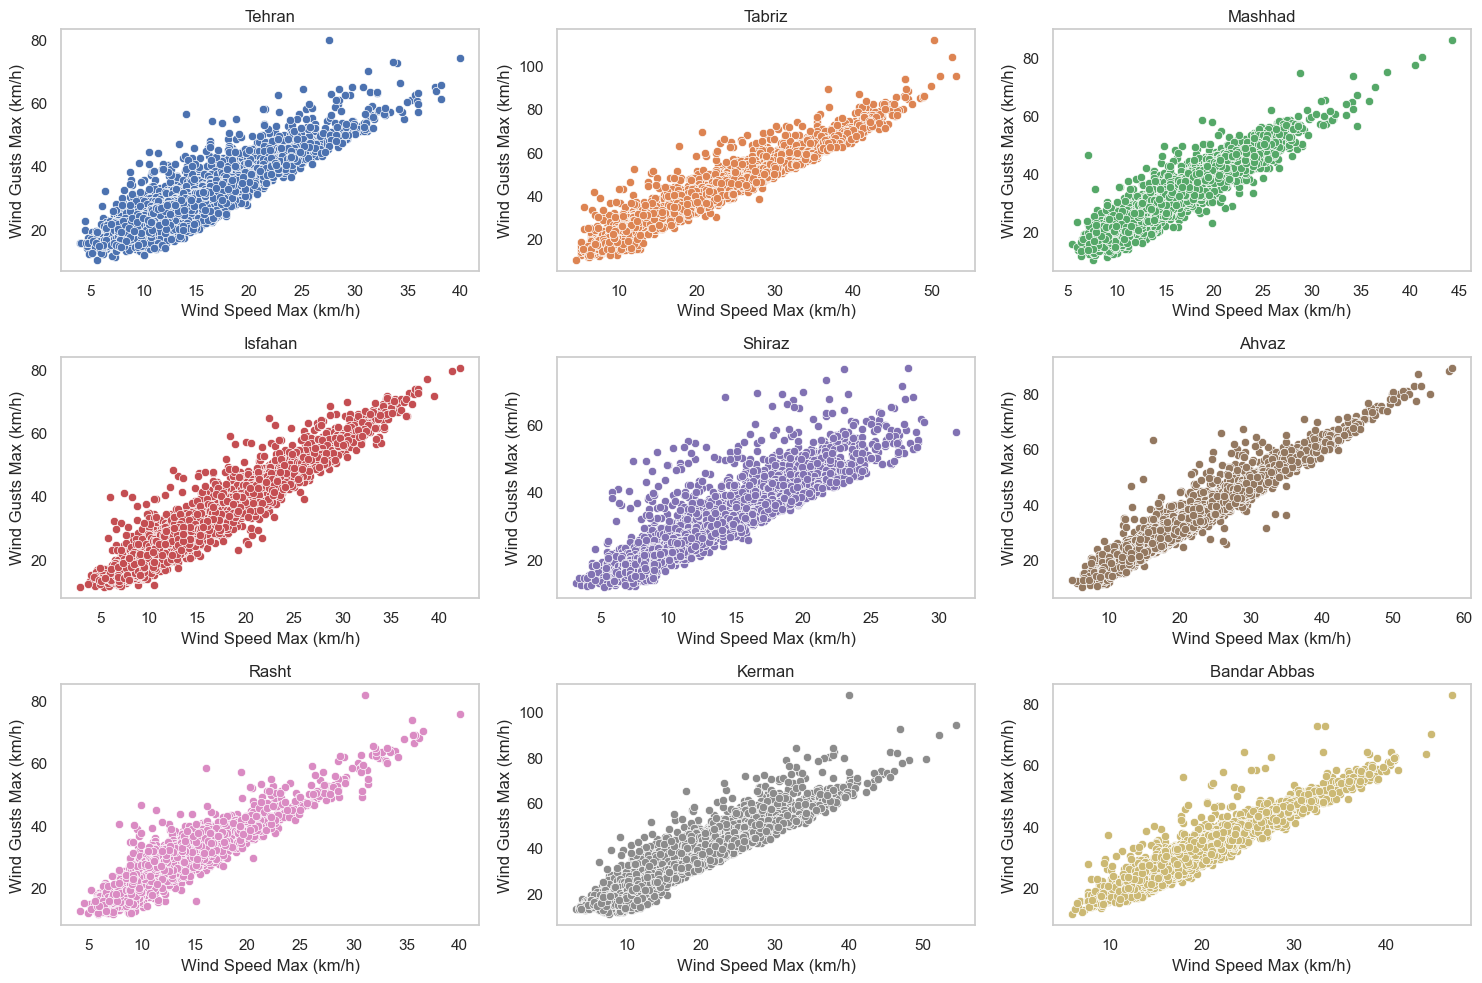

In [260]:
filtered_df = df[df['city'] != 'Karaj']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes
cities = filtered_df['city'].unique()

for i, city in enumerate(cities):
    subset = filtered_df[filtered_df['city'] == city]
    sns.scatterplot(data=subset, x='wind_speed_max (km/h)', y='wind_gusts_max (km/h)', ax=axes[i], color=sns.color_palette('deep')[i])
    axes[i].set_title(city)
    axes[i].set_xlabel('Wind Speed Max (km/h)')
    axes[i].set_ylabel('Wind Gusts Max (km/h)')
    axes[i].grid()

plt.tight_layout()
plt.show()

del filtered_df, cities, subset, axes, city, i, fig

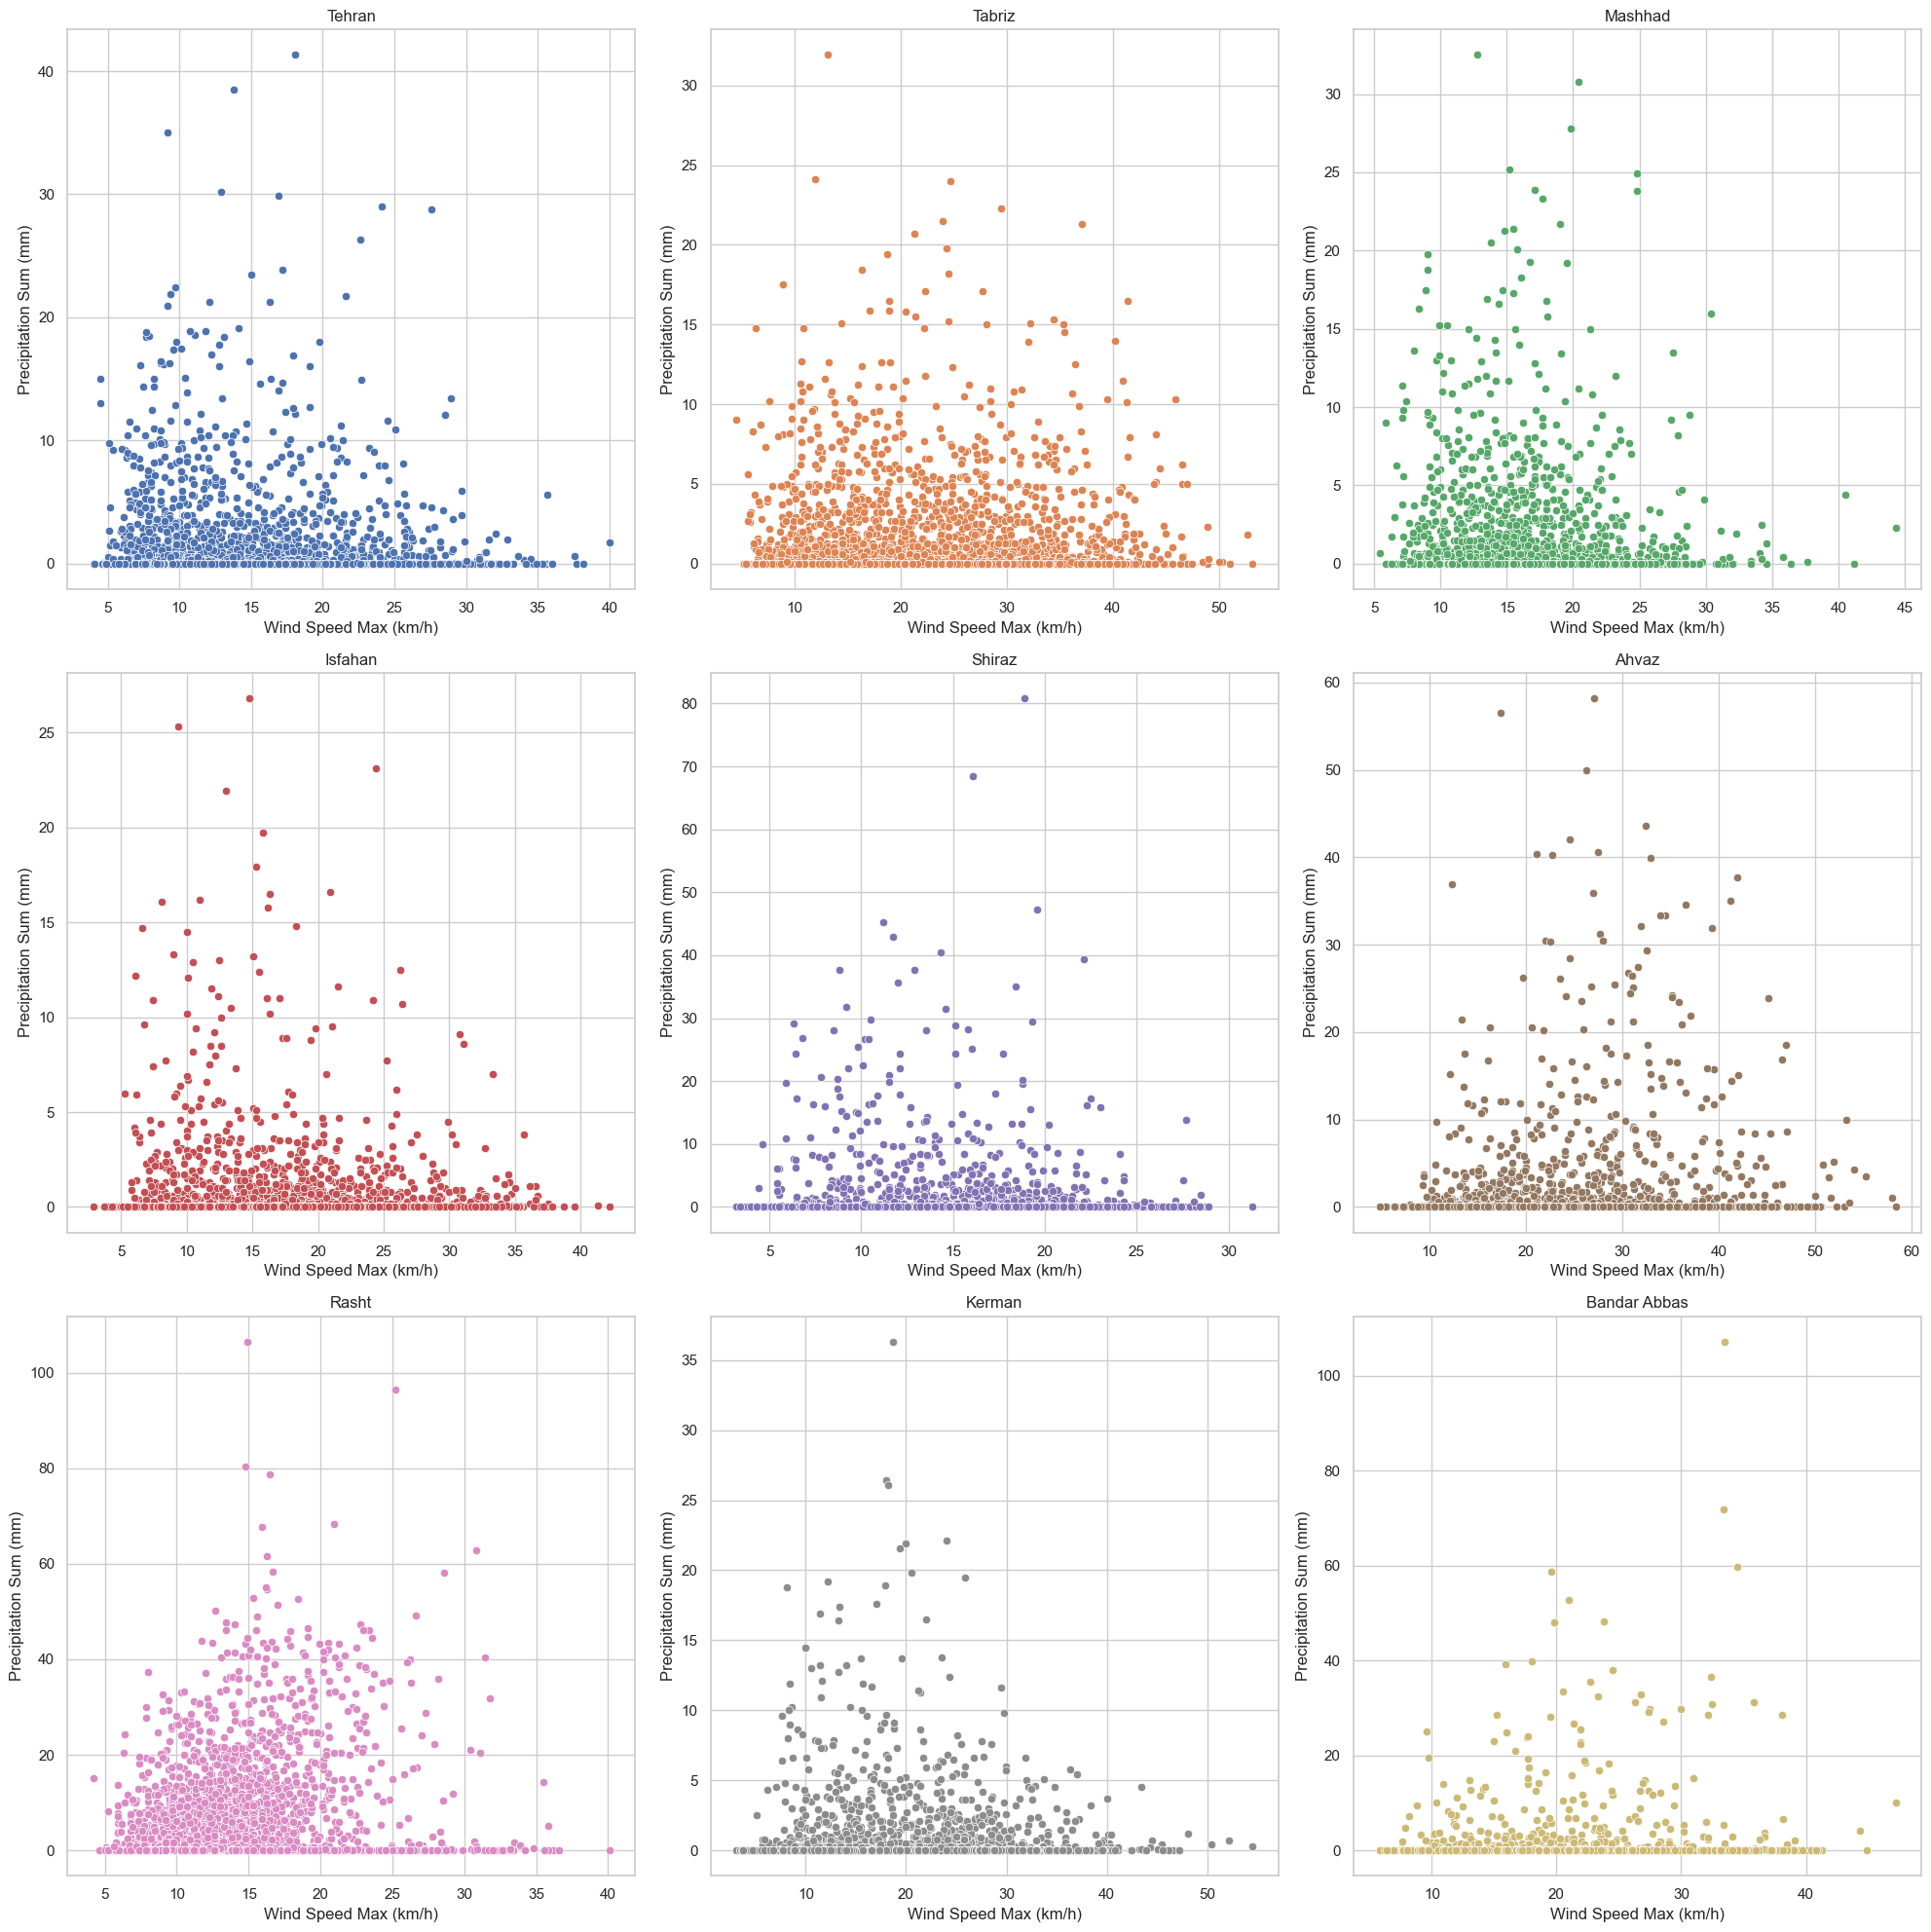

In [261]:
df_filtered = df[df['city'] != 'Karaj']
cities = df_filtered['city'].unique()
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()  # Flatten the array of axes for easy indexing

for i, city in enumerate(cities):
    city_data = df_filtered[df_filtered['city'] == city]
    sns.scatterplot(data=city_data, x='wind_speed_max (km/h)', y='precipitation_sum (mm)', ax=axs[i], color=sns.color_palette('deep')[i])
    axs[i].set_title(city)
    axs[i].set_xlabel('Wind Speed Max (km/h)')
    axs[i].set_ylabel('Precipitation Sum (mm)')

plt.tight_layout()
plt.show()

del city_data, cities, df_filtered, fig, axs, city, i

### Wind Speed Seasonal Box Plot

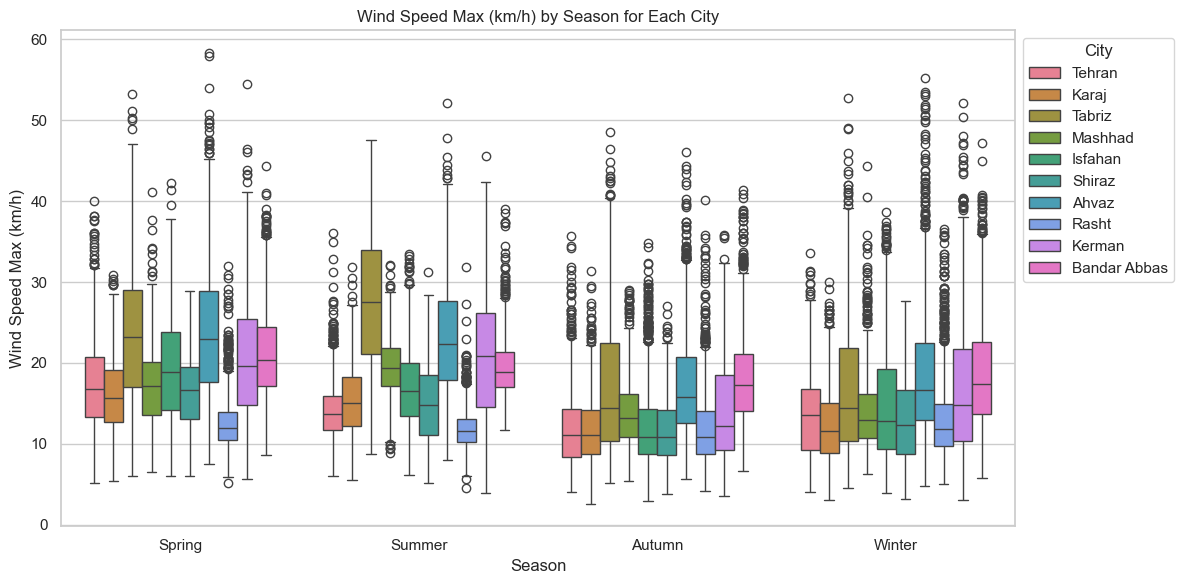

In [262]:
sns.set(style="whitegrid", palette="hsv")

plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='wind_speed_max (km/h)', hue='city', data=df)

plt.title('Wind Speed Max (km/h) by Season for Each City')
plt.xlabel('Season')
plt.ylabel('Wind Speed Max (km/h)')
plt.legend(title='City', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Wind Speed Correlation

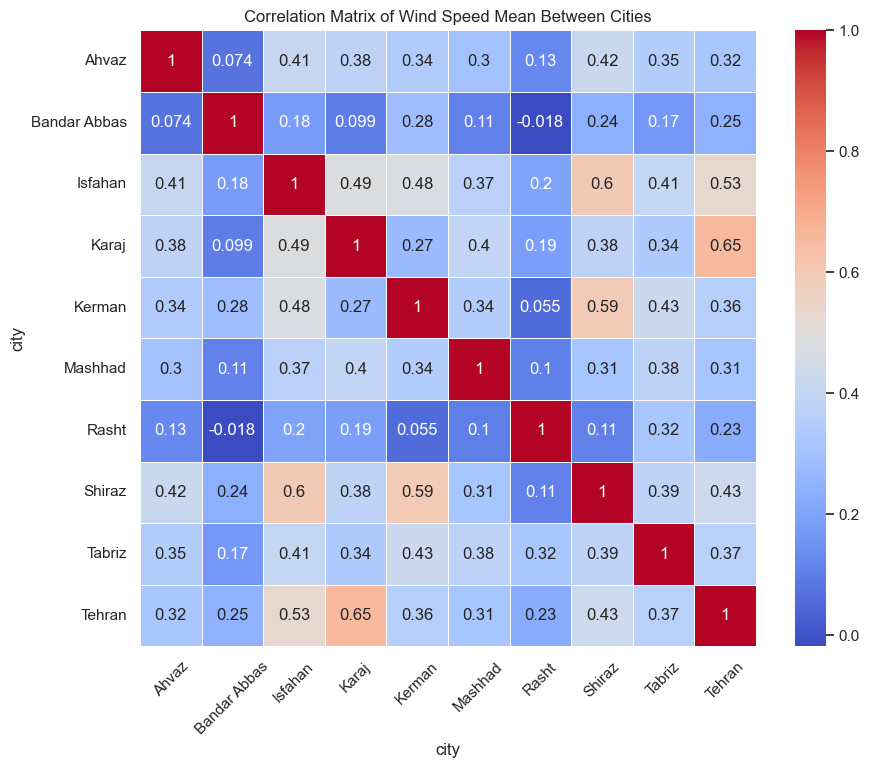

In [263]:
df_pivot = df.pivot_table(index='date_gregorian', columns='city', values='wind_speed_max (km/h)')
correlation_matrix = df_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, square=True)
plt.title('Correlation Matrix of Wind Speed Mean Between Cities')
plt.xticks(rotation=45)
plt.show()

del correlation_matrix, df_pivot

## Seasonal Daylight Duration

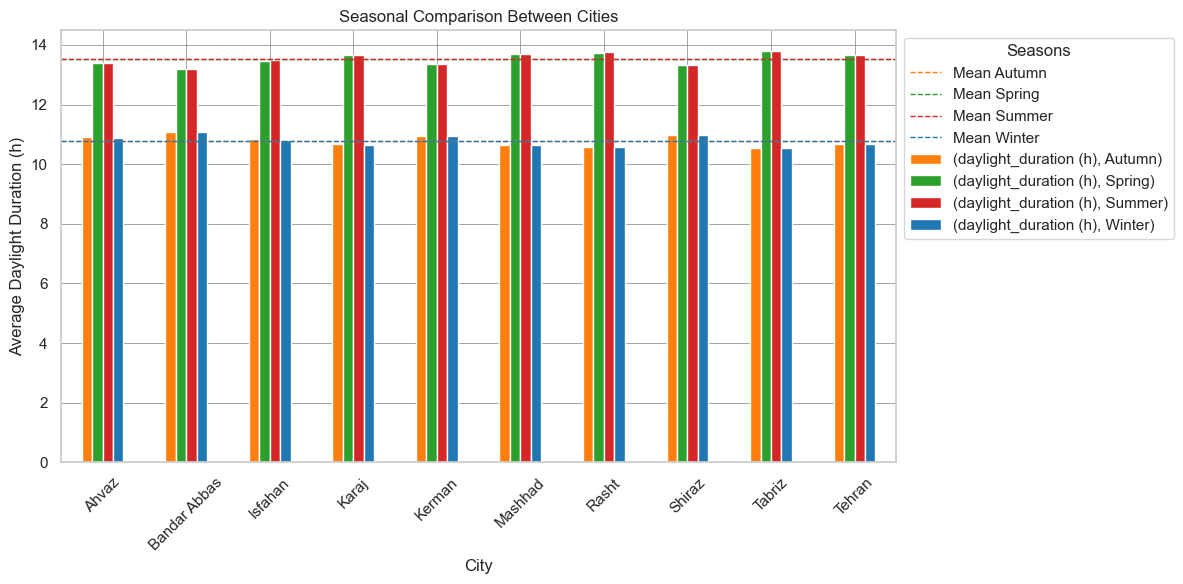

In [264]:
city_season_trends = df.groupby(['city', 'season']).agg({
    'daylight_duration (h)': 'mean',
}).unstack()
pallet = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4']

seasonal_means = df.groupby('season')['daylight_duration (h)'].mean().reset_index()

ax = city_season_trends.plot(kind='bar', figsize=(12, 6), title="Seasonal Comparison Between Cities", color=pallet)

for i, mean in enumerate(seasonal_means['daylight_duration (h)']):
    ax.axhline(y=mean, color=pallet[i], linestyle='--', linewidth=1, label=f'Mean {seasonal_means["season"].iloc[i]}')
    
ax.set_xlabel("City")
ax.set_ylabel("Average Daylight Duration (h)")
plt.legend(title='Seasons', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, color='gray', linewidth=0.5) 
plt.tight_layout()
plt.show()

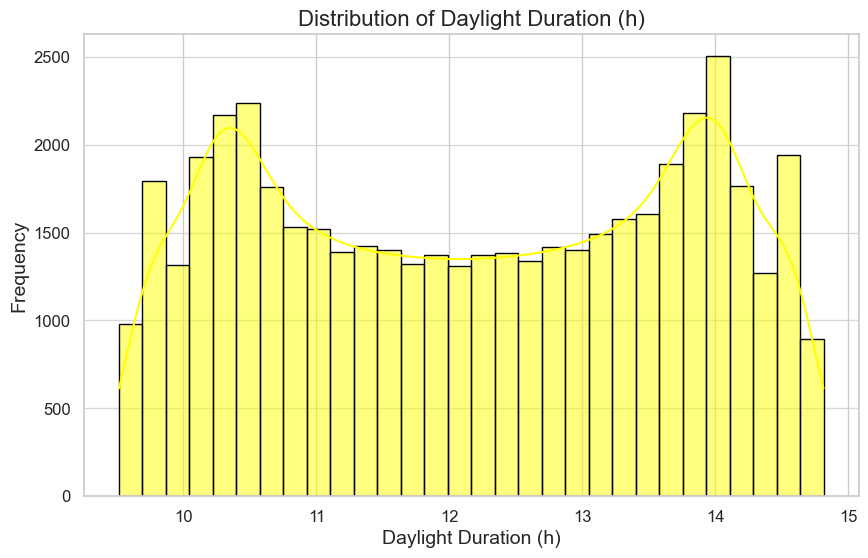

In [276]:
data = df[(1390 <= df['year']) & (df['year'] < 1403)]
plt.figure(figsize=(10, 6))
sns.histplot(data['daylight_duration (h)'], bins=30, color='yellow', edgecolor='black', kde=True)
plt.title('Distribution of Daylight Duration (h)', fontsize=16)
plt.xlabel('Daylight Duration (h)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Elevation & Shortwave-Radiation Impact Analysis

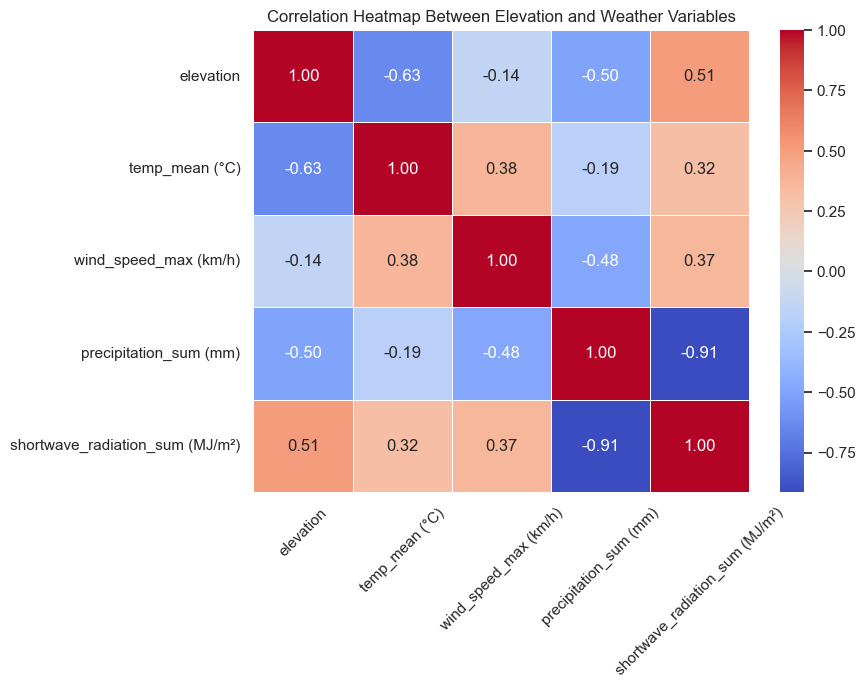

In [265]:
# Group the data by 'city' and calculate mean values
city_grouped = df.groupby('city').agg({
    'elevation': 'mean',
    'temp_mean (°C)': 'mean',
    'wind_speed_max (km/h)': 'mean',
    'precipitation_sum (mm)': 'mean',
    'shortwave_radiation_sum (MJ/m²)': 'mean'
}).reset_index()

# HEATMAP
correlation_matrix = city_grouped[['elevation',
                                   'temp_mean (°C)',
                                   'wind_speed_max (km/h)',
                                   'precipitation_sum (mm)',
                                   'shortwave_radiation_sum (MJ/m²)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap Between Elevation and Weather Variables')
plt.xticks(rotation=45)
plt.show()

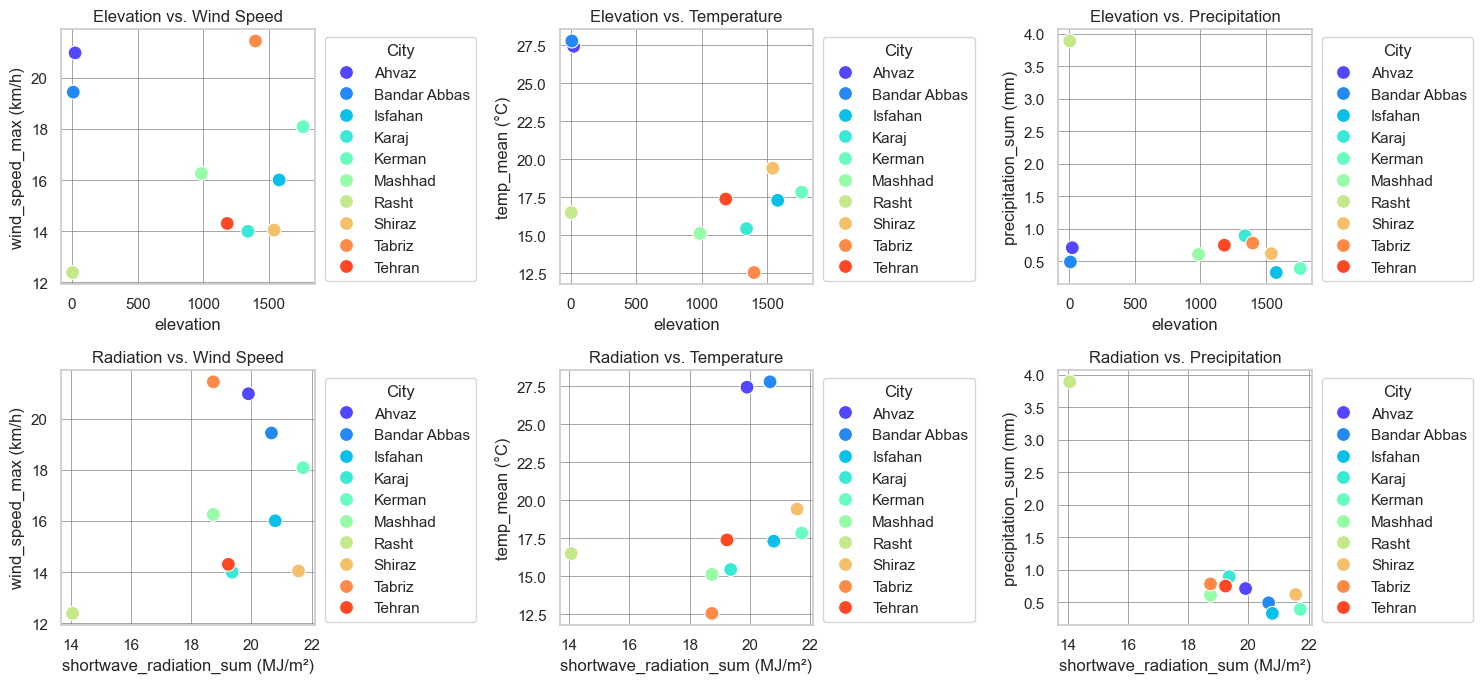

In [268]:
scale = 100

# SCATTER PLOT
plt.figure(figsize=(15, 7))
rainbow_palette = sns.color_palette("rainbow", len(city_grouped['city'].unique()))

# Elevation vs Wind 
plt.subplot(2, 3, 1)
sns.scatterplot(x='elevation', y='wind_speed_max (km/h)', hue='city', data=city_grouped, 
                palette=rainbow_palette, s=scale) 
plt.title('Elevation vs. Wind Speed')
plt.legend(title='City', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 

# Elevation vs. Temperature
plt.subplot(2, 3, 2)
sns.scatterplot(x='elevation', y='temp_mean (°C)', hue='city', data=city_grouped, 
                palette=rainbow_palette, s=scale)
plt.title('Elevation vs. Temperature')
plt.legend(title='City', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 

# Radiation vs Precipitation
plt.subplot(2, 3, 3)
sns.scatterplot(x='elevation', y='precipitation_sum (mm)', hue='city', data=city_grouped, 
                palette=rainbow_palette, s=scale)
plt.title('Elevation vs. Precipitation')
plt.legend(title='City', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 

# Radiation vs Wind 
plt.subplot(2, 3, 4)
sns.scatterplot(x='shortwave_radiation_sum (MJ/m²)', y='wind_speed_max (km/h)', hue='city', data=city_grouped, 
                palette=rainbow_palette, s=scale) 
plt.title('Radiation vs. Wind Speed')
plt.legend(title='City', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 

# Radiation vs. Temperature
plt.subplot(2, 3, 5)
sns.scatterplot(x='shortwave_radiation_sum (MJ/m²)', y='temp_mean (°C)', hue='city', data=city_grouped, 
                palette=rainbow_palette, s=scale)
plt.title('Radiation vs. Temperature')
plt.legend(title='City', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 

# Radiation vs Precipitation
plt.subplot(2, 3, 6)
sns.scatterplot(x='shortwave_radiation_sum (MJ/m²)', y='precipitation_sum (mm)', hue='city', data=city_grouped, 
                palette=rainbow_palette, s=scale)
plt.title('Radiation vs. Precipitation')
plt.legend(title='City', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, color='gray', linewidth=0.5) 

plt.tight_layout()
plt.show()

del scale, correlation_matrix, city_grouped

array([<Axes: title={'center': 'temp_mean (°C)'}, xlabel='city'>,
       <Axes: title={'center': 'precipitation_sum (mm)'}, xlabel='city'>,
       <Axes: title={'center': 'wind_speed_max (km/h)'}, xlabel='city'>],
      dtype=object)

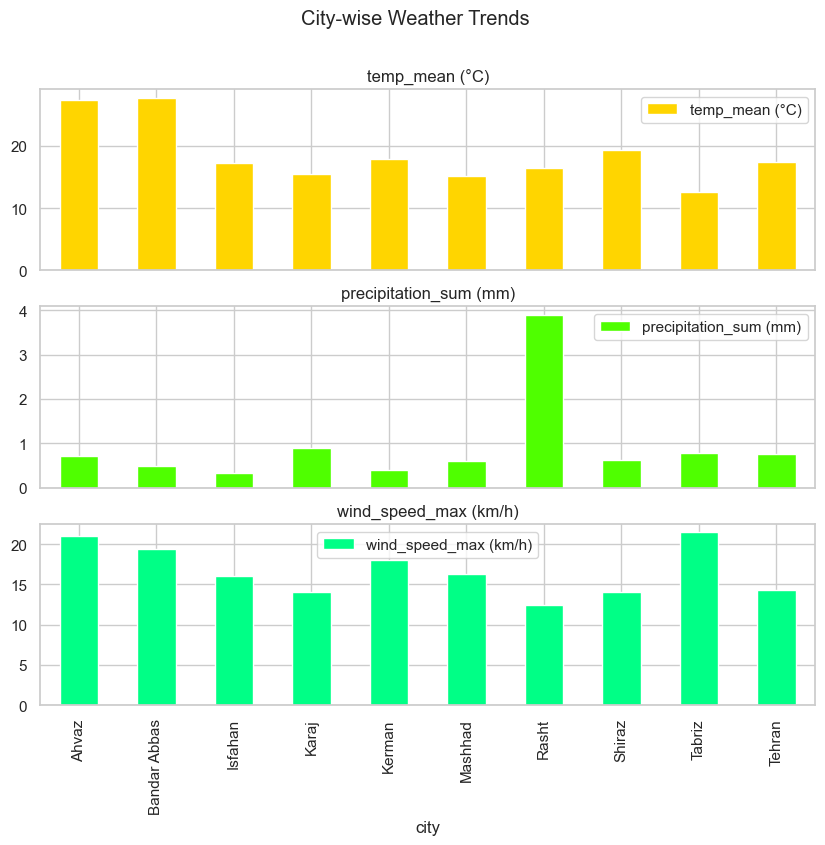

In [267]:
city_trends = df.groupby('city').agg({
    'temp_mean (°C)': 'mean',
    'precipitation_sum (mm)': 'mean',
    'wind_speed_max (km/h)': 'mean'
})
city_trends.plot(kind='bar', subplots=True, figsize=(10, 8), title="City-wise Weather Trends")